### Prétraitement des données
Avant d'entraîner les modèles, les données doivent être nettoyées et organisées. Cette étape permet d'assurer la cohérence et la qualité des données, ce qui impacte directement les performances des modèles. Nous effectuons les opérations suivantes :
- Suppression des valeurs manquantes
- Encodage des variables catégoriques
- Normalisation des valeurs numériques si nécessaire
- Séparation des données en ensembles d'entraînement et de test


## Chargement et Exploration des Données

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import os

# Charger les fichiers CSV
general_data = pd.read_csv("datasets/raw/general_data.csv")
manager_survey = pd.read_csv("datasets/raw/manager_survey_data.csv")
employee_survey = pd.read_csv("datasets/raw/employee_survey_data.csv")

# Extraire et charger les fichiers ZIP contenant les horaires de travail
with zipfile.ZipFile("datasets/in_out_time.zip", "r") as zip_ref:
    zip_ref.extractall("datasets/in_out_time")

# Charger les fichiers horaires
in_time = pd.read_csv("datasets/in_out_time/in_time.csv")
out_time = pd.read_csv("datasets/in_out_time/out_time.csv")


In [5]:
#faire une copie du dataset general_data afin d'éviter tout soucis
general_data_copy = general_data.copy()


In [6]:
#  employee_survey_data et manager_survey_data sont joints via la colonne "EmployeeID"
general_data_copy = general_data_copy.join(employee_survey.set_index("EmployeeID"), on="EmployeeID")
general_data_copy = general_data_copy.join(manager_survey.set_index("EmployeeID"), on="EmployeeID")


In [7]:
# Aperçu des datasets
general_data_copy.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [8]:
# Vérifier les types de données et les valeurs nulles
general_data_copy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [9]:
# Vérifier les valeurs uniques des colonnes catégoriques
general_data_copy.nunique()

Age                          43
Attrition                     2
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeID                 4410
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1349
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
EnvironmentSatisfaction       4
JobSatisfaction               4
WorkLifeBalance               4
JobInvolvement                4
PerformanceRating             2
dtype: int64

## Nettoyage des Données

In [11]:

# Drop columns where all values are NaN and replace NaN with 0
in_time = in_time.dropna(axis=1, how='all').replace(0, np.nan)
out_time = out_time.dropna(axis=1, how='all').replace(0, np.nan)

# Convert to datetime while handling missing values
for col in in_time.columns[1:]:
    in_time[col] = pd.to_datetime(in_time[col], errors='coerce')

for col in out_time.columns[1:]:
    out_time[col] = pd.to_datetime(out_time[col], errors='coerce')

# Convert to Unix timestamp (seconds)
for col in in_time.columns[1:]:
    in_time[col] = in_time[col].astype('int64') // 10**9

for col in out_time.columns[1:]:
    out_time[col] = out_time[col].astype('int64') // 10**9


in_time = in_time.sort_values(by="Unnamed: 0", ascending=True)
out_time = out_time.sort_values(by="Unnamed: 0", ascending=True)


Nous devons calculer le temps de travail quotidien de chaque employé en soustrayant l'heure d'entrée (`in_time`) et l'heure de sortie (`out_time`).

Le dataset contient une colonne d'identification avec les ID uniques des employés. Lors de la soustraction (`out_time - in_time`), Pandas aligne les colonnes selon leurs noms. Si l'ID employé n'est pas correctement géré, il peut être affecté par cette opération.

Pour éviter cela, nous appliquons une transformation avant la soustraction..



In [13]:
out_time["Unnamed: 0"] = out_time["Unnamed: 0"] + out_time["Unnamed: 0"]
time = out_time.subtract(in_time, axis=1)

Une fois le calcul du temps de travail quotidien terminé, nous effectuons une autre soustraction : le temps de travail journalier de l'employé moins les heures de travail prévues dans son contrat.

Les valeurs négatives (retards) sont remplacées par -1 et les valeurs positives (heures supplémentaires) par 1.

Enfin, nous faisons la somme de ces valeurs pour obtenir un score annuel d'assiduité pour chaque employé, stocké dans la colonne `AttendanceScore`., this time between the daily time worked by the employee and the daily working hours stated in their contract.



In [15]:
time_tmp = time.copy()
time_tmp = time_tmp.join(general_data.set_index("EmployeeID"), on="Unnamed: 0")
time_tmp["EmployeeID"] = time_tmp["Unnamed: 0"]
time_tmp["StandardHours"] = time_tmp["StandardHours"] * 3600
time_tmp["AttendanceScore"] = 0

for date in time_tmp.keys()[1:len(time.keys()[1:]) +1]:        
    time_tmp[date] = time_tmp[date] - time_tmp["StandardHours"]
    time_tmp[date] = time_tmp[date].where(time_tmp[date] > 0, -1)
    time_tmp[date] = time_tmp[date].where(time_tmp[date] < 0, 1)
    time_tmp["AttendanceScore"] = time_tmp["AttendanceScore"] + time_tmp[date]

In [16]:
# add the new column to the general data copy
general_data_copy = pd.merge(general_data_copy,time_tmp[['EmployeeID', 'AttendanceScore']],on='EmployeeID', how='left')
print(general_data_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [ ]:
# supression des donnés 
general_data_copy.drop(['EmployeeID'], axis=1, inplace=True)
general_data_copy.drop(['Over18'], axis=1, inplace=True)
general_data_copy.drop(['EmployeeCount'], axis=1, inplace=True)
general_data_copy.drop(['StandardHours'], axis=1, inplace=True)
general_data_copy.drop(['Gender'], axis=1, inplace=True)
general_data_copy.drop(['StockOptionLevel'], axis=1, inplace=True)
general_data_copy.drop(['Age'], axis=1, inplace=True)
general_data_copy.drop(['WorkLifeBalance'], axis=1, inplace=True)




In [18]:
# Compter les valeurs nulles
general_data_copy.isnull().sum()


Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
PercentSalaryHike           0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
AttendanceScore             0
dtype: int64

In [19]:
# Remplacer les valeurs manquantes par la médiane
incomplete_variables = ["JobSatisfaction","EnvironmentSatisfaction","WorkLifeBalance", "NumCompaniesWorked","TotalWorkingYears"]
for variable in incomplete_variables:
	median = general_data_copy[variable].median()
	general_data_copy[variable].fillna(median, inplace=True)

general_data_copy.isnull().sum()

C:\Users\issam\AppData\Local\Temp\ipykernel_18148\4001221799.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  general_data_copy[variable].fillna(median, inplace=True)


Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
AttendanceScore            0
dtype: int64

In [20]:
general_data_copy.describe(include="all")


,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
count,4410,4410,4410,4410.000000,4410.000000,4410,4410.000000,4410,4410,4410.000000,...,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
unique,2,3,3,NaN,NaN,6,NaN,9,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,No,Travel_Rarely,Research & Development,NaN,NaN,Life Sciences,NaN,Sales Executive,Married,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3699,3129,2883,NaN,NaN,1818,NaN,978,2019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.192517,2.912925,NaN,2.063946,NaN,NaN,65029.312925,...,2.799320,7.008163,2.187755,4.123129,2.725170,2.729478,2.763492,2.729932,3.153741,-96.693878
std,NaN,NaN,NaN,8.105026,1.023933,NaN,1.106689,NaN,NaN,47068.888559,...,1.288978,6.125135,3.221699,3.567327,1.089852,1.098904,0.703541,0.711400,0.360742,200.040122
min,NaN,NaN,NaN,1.000000,1.000000,NaN,1.000000,NaN,NaN,10090.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,-249.000000
25%,NaN,NaN,NaN,2.000000,2.000000,NaN,1.000000,NaN,NaN,29110.000000,...,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,-249.000000
50%,NaN,NaN,NaN,7.000000,3.000000,NaN,2.000000,NaN,NaN,49190.000000,...,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,-237.000000
75%,NaN,NaN,NaN,14.000000,4.000000,NaN,3.000000,NaN,NaN,83800.000000,...,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,161.000000


In [21]:
# We will modify the following data to have results that are easier to analyze

general_data_copy['PerformanceRating'] = general_data_copy['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
general_data_copy['EnvironmentSatisfaction'] = general_data_copy['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
general_data_copy['JobSatisfaction'] = general_data_copy['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
general_data_copy['JobInvolvement'] = general_data_copy['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
general_data_copy['WorkLifeBalance'] = general_data_copy['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})
general_data_copy['Education'] = general_data_copy['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
general_data_copy['JobLevel'] = general_data_copy["JobLevel"].replace({ 1 : 'Apprentice', 2: 'Junior Employee',3: 'Employee',4: 'Manager',5 : 'Director'})

In [22]:
general_data_copy.head(10)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
0,No,Travel_Rarely,Sales,6,College,Life Sciences,Apprentice,Healthcare Representative,Married,131160,...,6,1,0,0,High,Very High,Good,High,Excellent,-249
1,Yes,Travel_Frequently,Research & Development,10,Below College,Life Sciences,Apprentice,Research Scientist,Single,41890,...,3,5,1,4,High,Medium,Best,Medium,Outstanding,-165
2,No,Travel_Frequently,Research & Development,17,Master,Other,Manager,Sales Executive,Married,193280,...,2,5,0,3,Medium,Medium,Bad,High,Excellent,-249
3,No,Non-Travel,Research & Development,2,Doctor,Life Sciences,Employee,Human Resources,Married,83210,...,5,8,7,5,Very High,Very High,Better,Medium,Excellent,-249
4,No,Travel_Rarely,Research & Development,10,Below College,Medical,Apprentice,Sales Executive,Single,23420,...,2,6,0,4,Very High,Low,Better,High,Excellent,-19
5,No,Travel_Rarely,Research & Development,8,Bachelor,Life Sciences,Manager,Research Director,Married,40710,...,5,7,7,7,High,Medium,Good,High,Excellent,225
6,Yes,Travel_Rarely,Research & Development,11,College,Medical,Junior Employee,Sales Executive,Single,58130,...,2,0,0,0,Low,High,Bad,High,Outstanding,-247
7,No,Travel_Rarely,Research & Development,18,Bachelor,Life Sciences,Junior Employee,Sales Executive,Married,31430,...,2,0,0,0,Low,Medium,Better,High,Outstanding,-249
8,No,Travel_Rarely,Research & Development,1,Bachelor,Life Sciences,Employee,Laboratory Technician,Married,20440,...,2,9,7,8,Medium,Very High,Better,High,Outstanding,-247
9,No,Non-Travel,Research & Development,7,Master,Medical,Manager,Laboratory Technician,Divorced,134640,...,2,6,1,5,Medium,Low,Better,High,Excellent,-249


array([[<Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>],
       [<Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'center': 'TrainingTimesLastYear'}>],
       [<Axes: title={'center': 'YearsAtCompany'}>,
        <Axes: title={'center': 'YearsSinceLastPromotion'}>,
        <Axes: title={'center': 'YearsWithCurrManager'}>],
       [<Axes: title={'center': 'AttendanceScore'}>, <Axes: >, <Axes: >]],
      dtype=object)

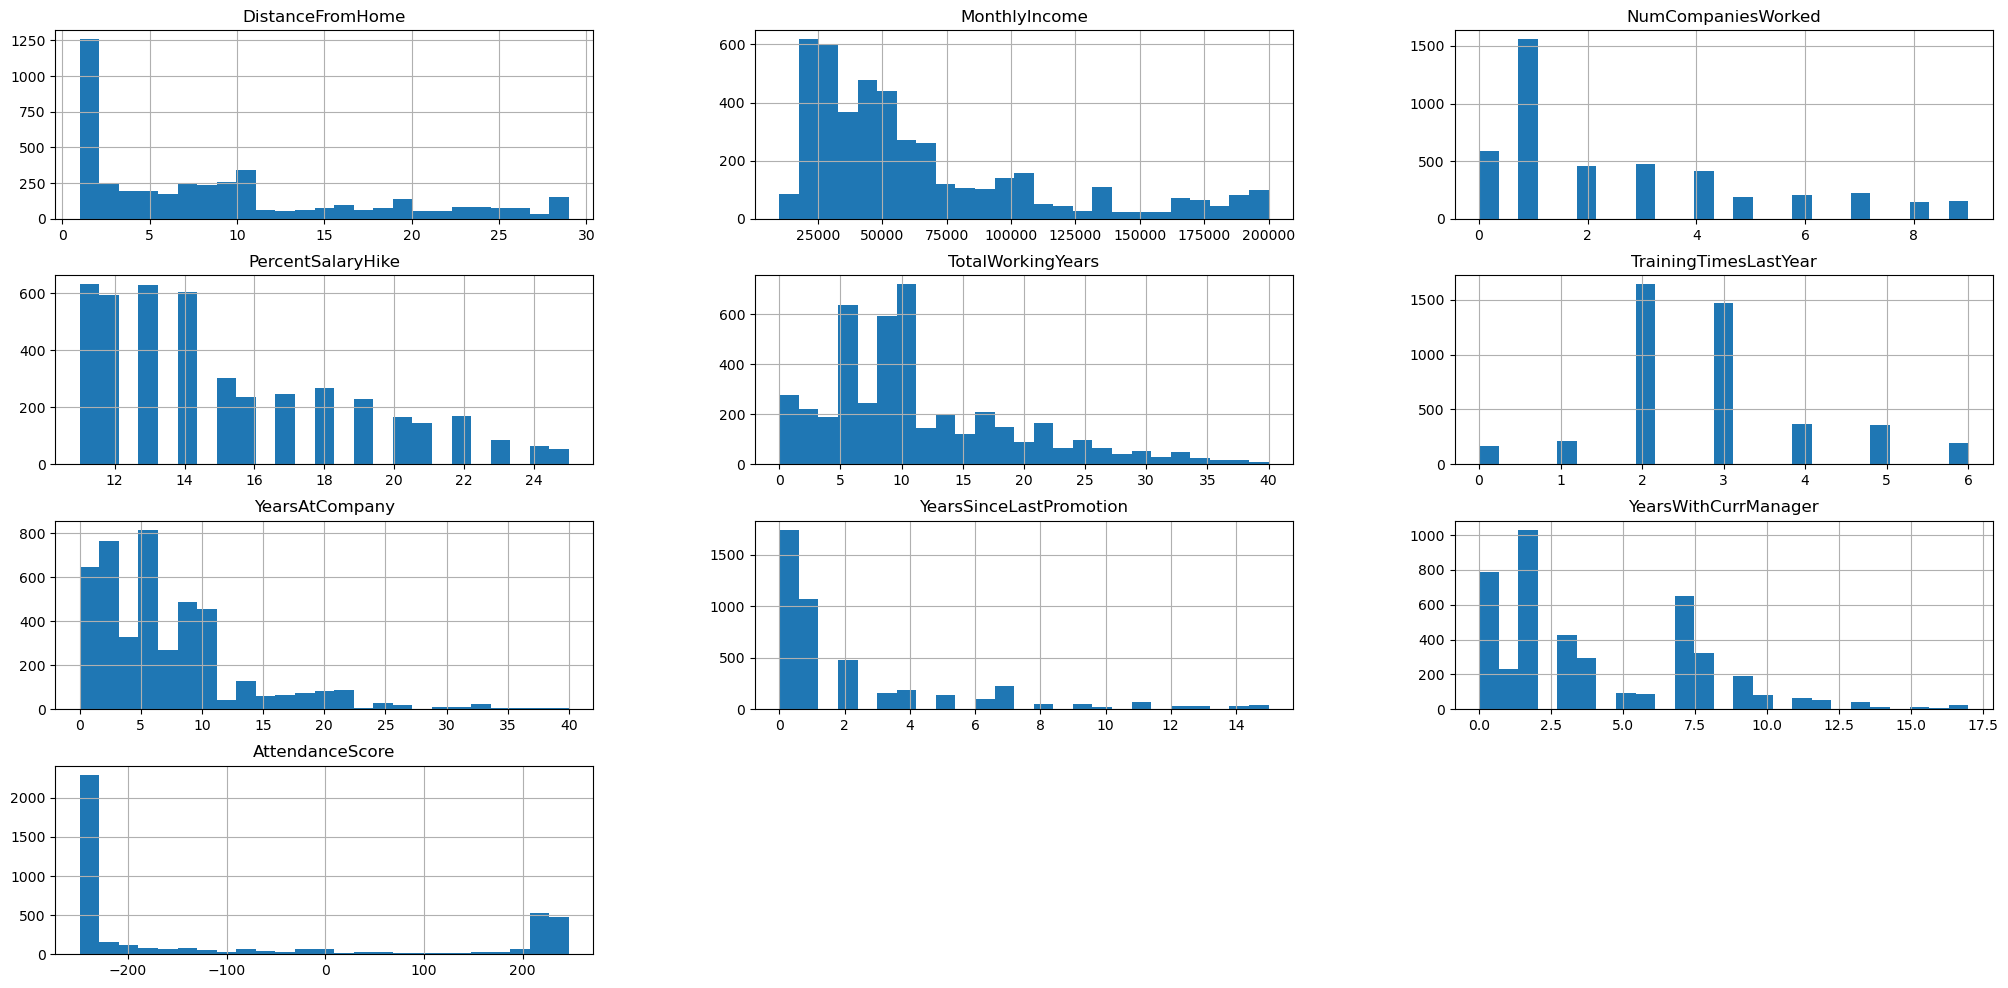

In [23]:
general_data_copy.hist(figsize=(25,12), bins=25,column=list(general_data_copy.columns))


Ci-dessous se trouvent tous les graphiques représentant les variables catégoriques du dataset :

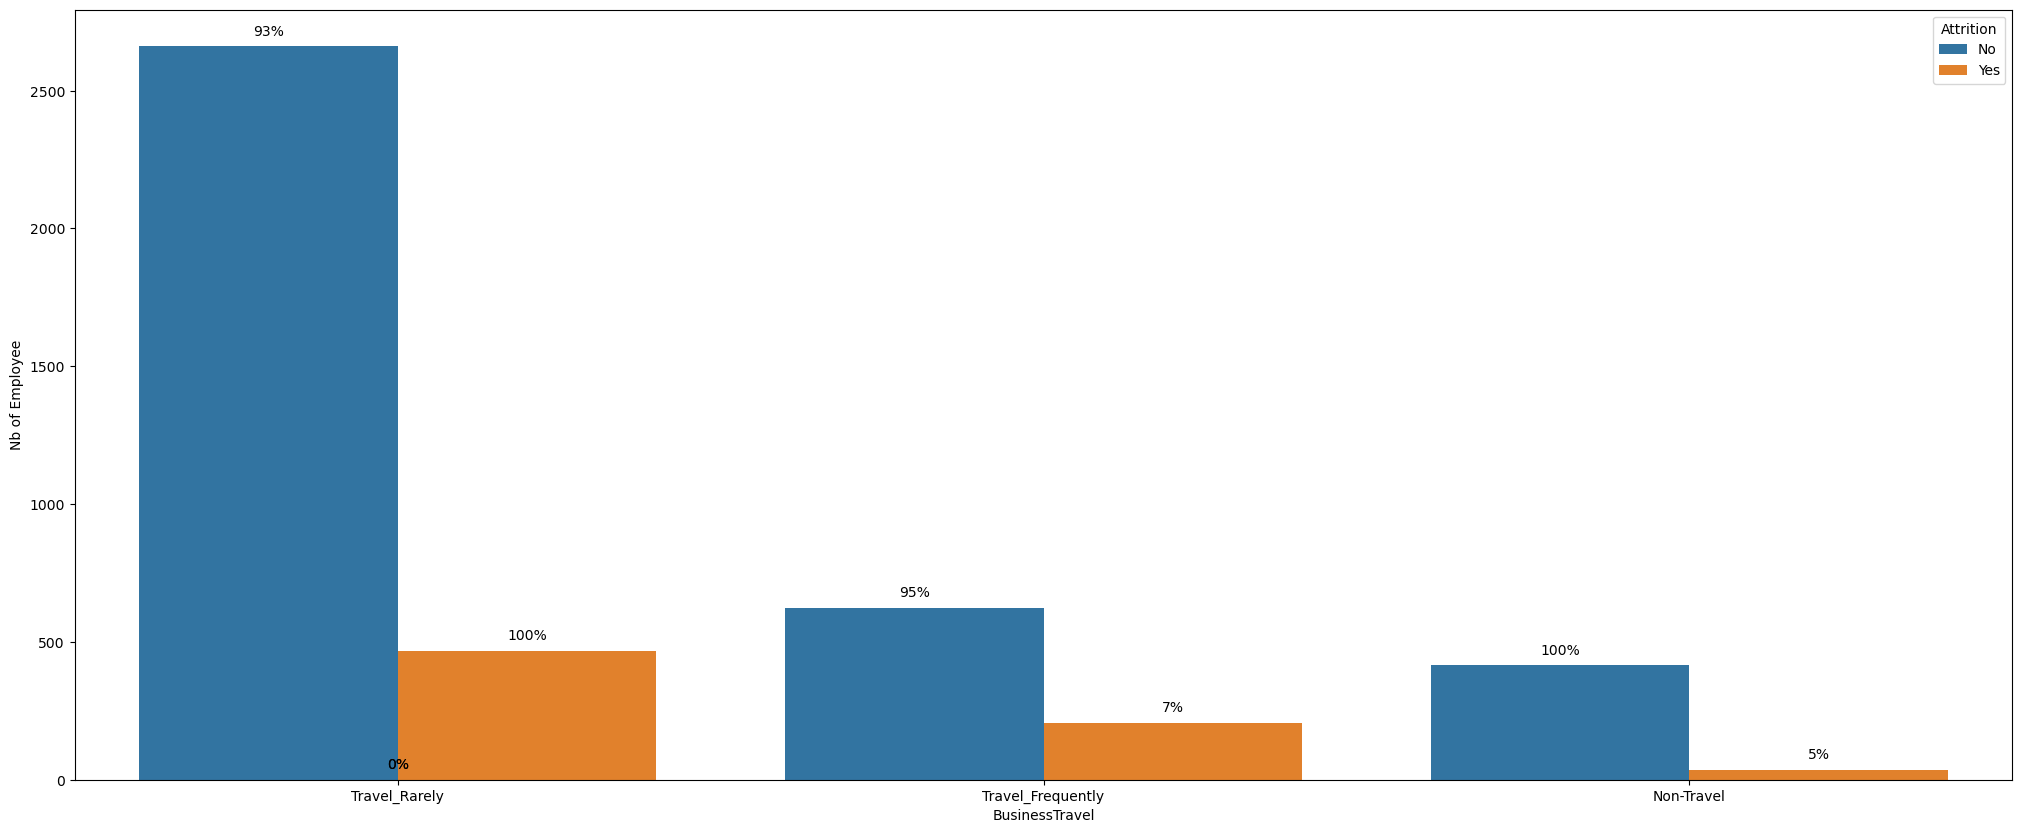

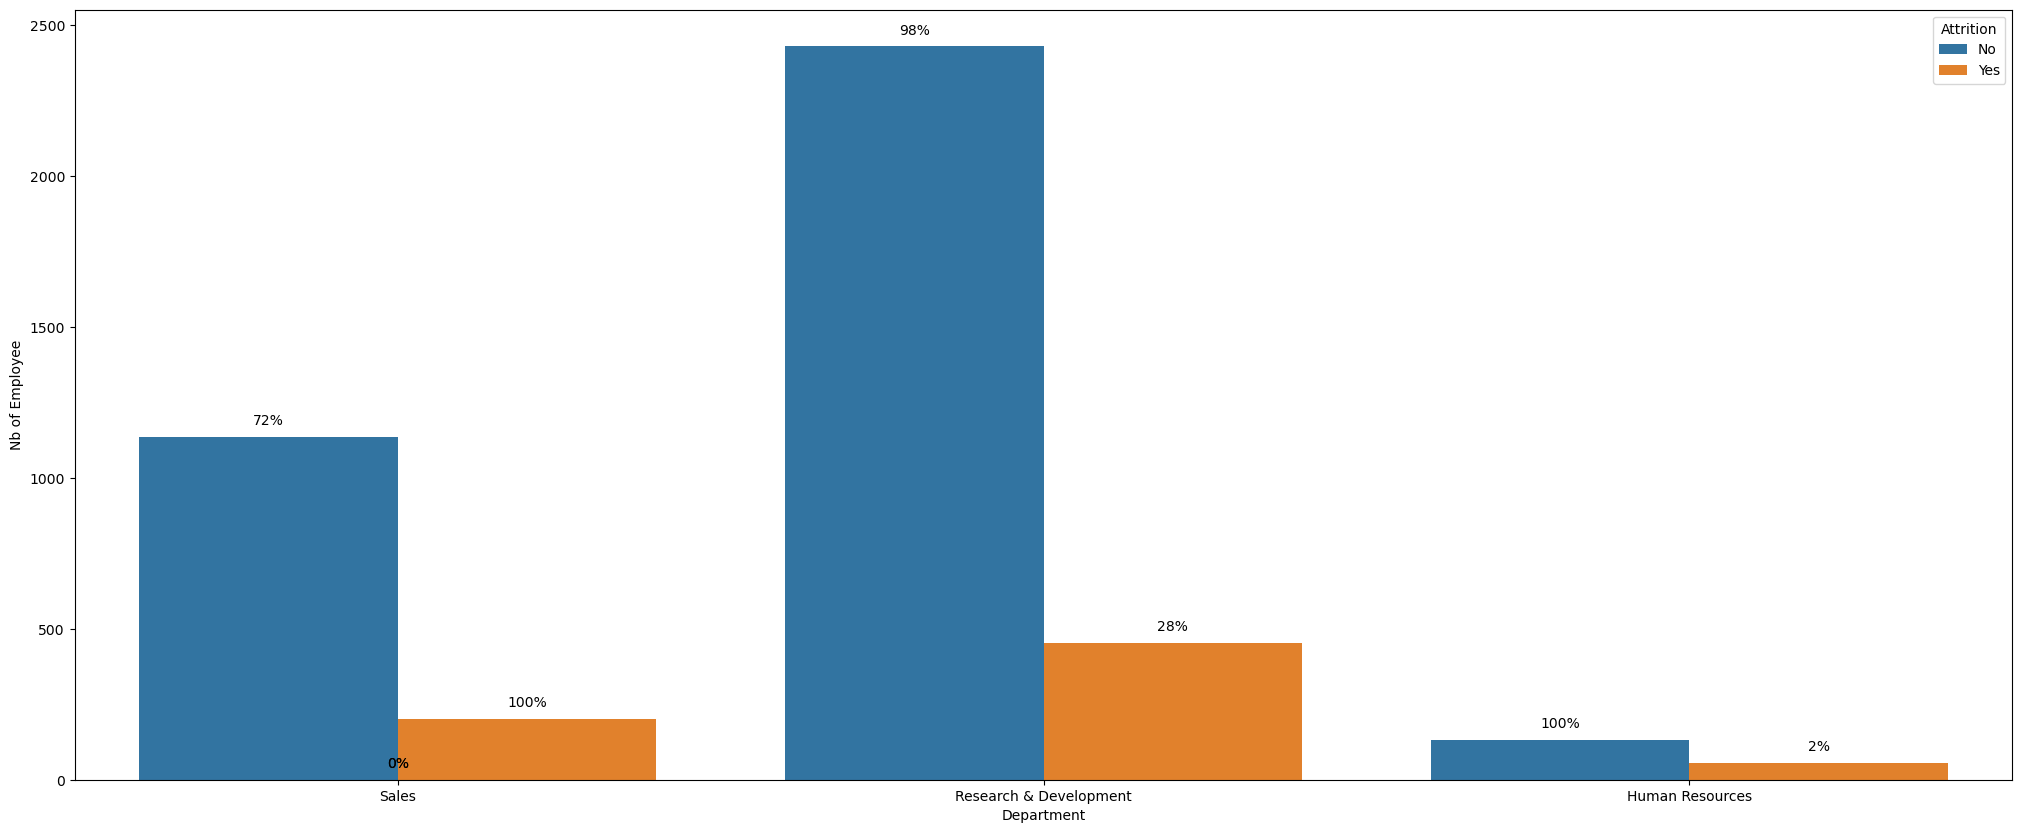

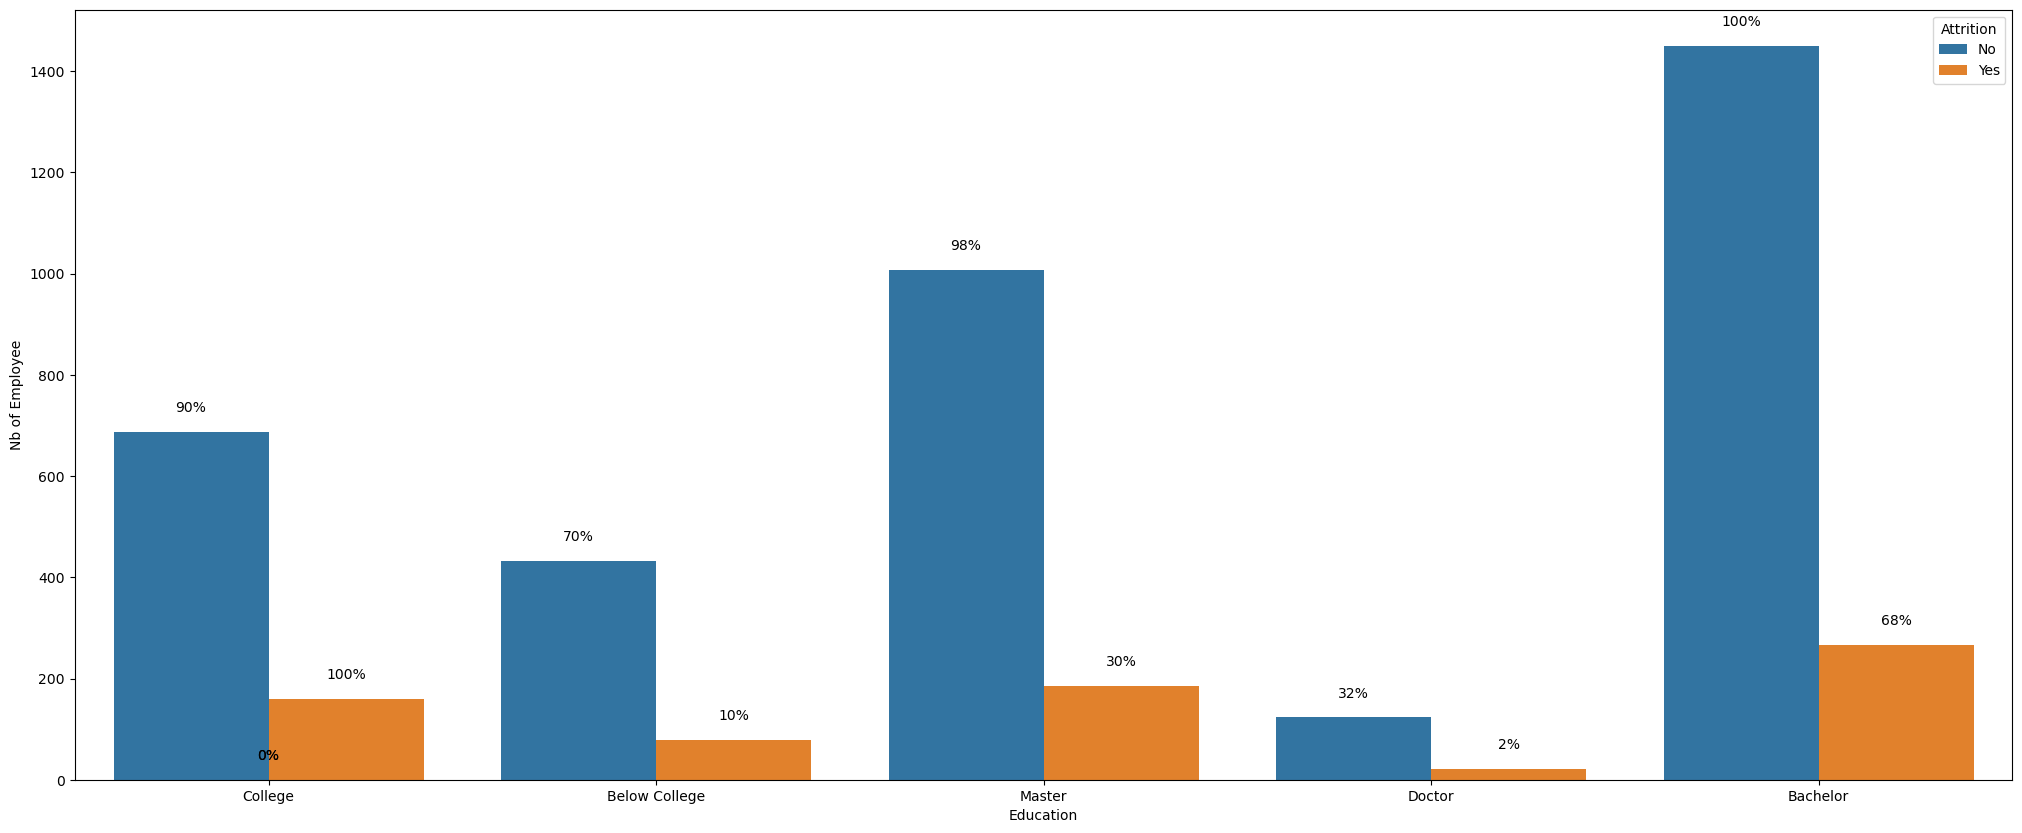

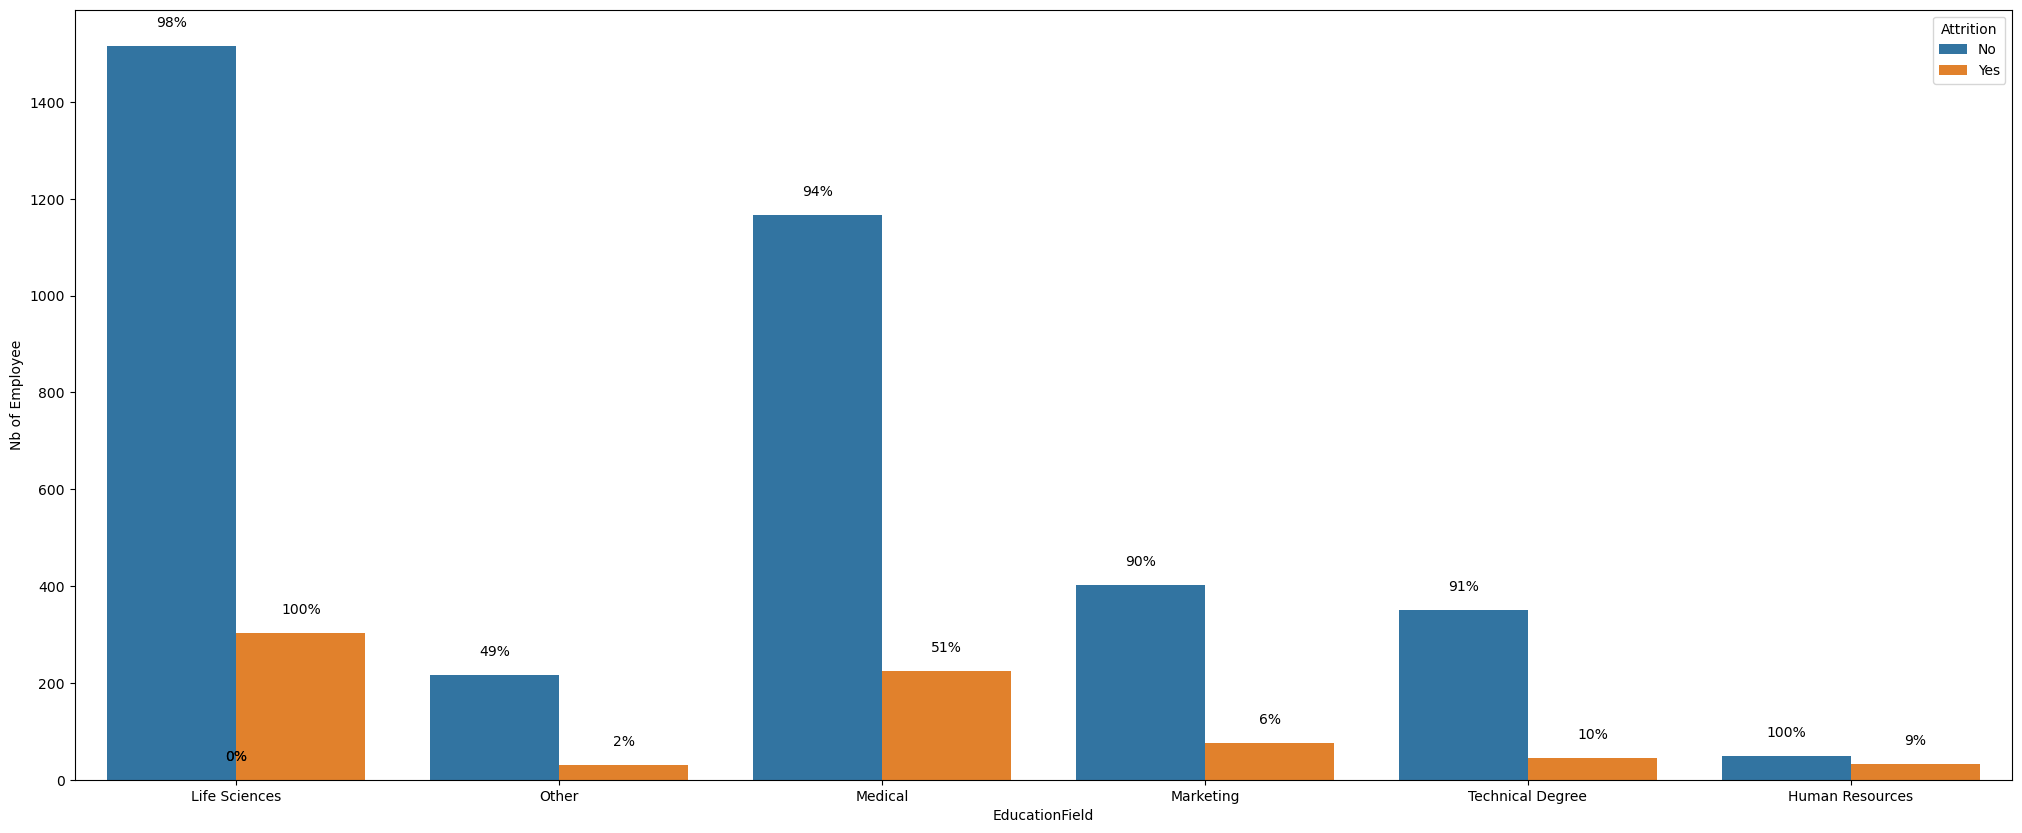

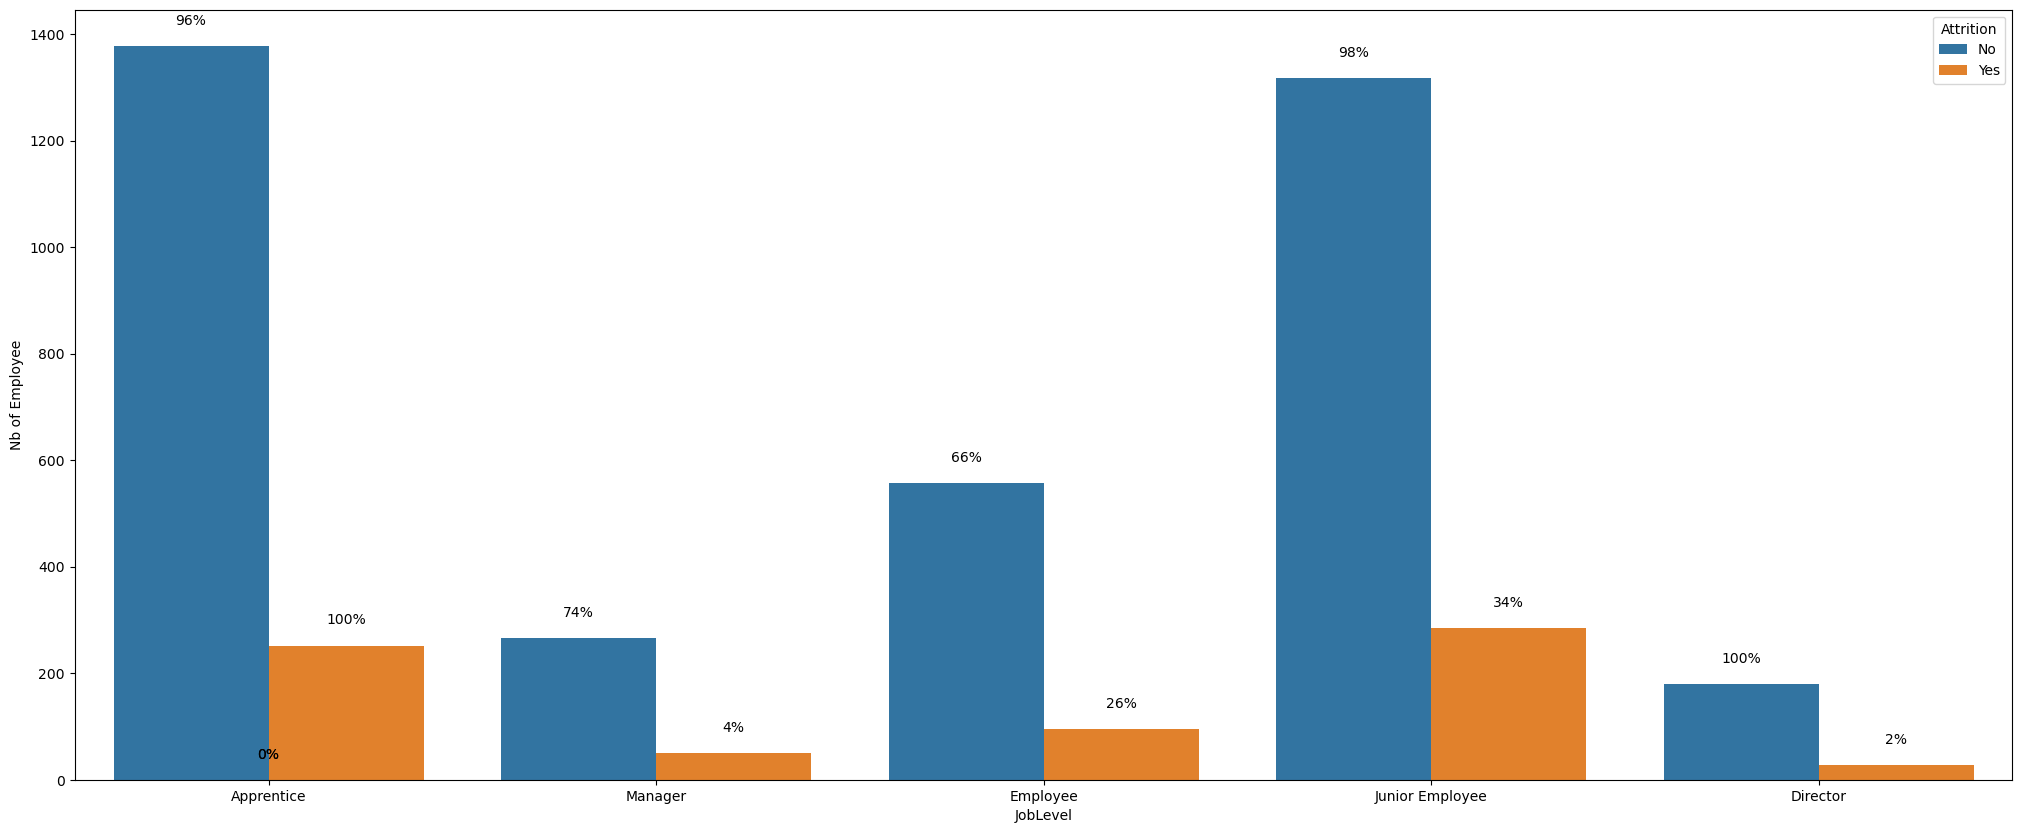

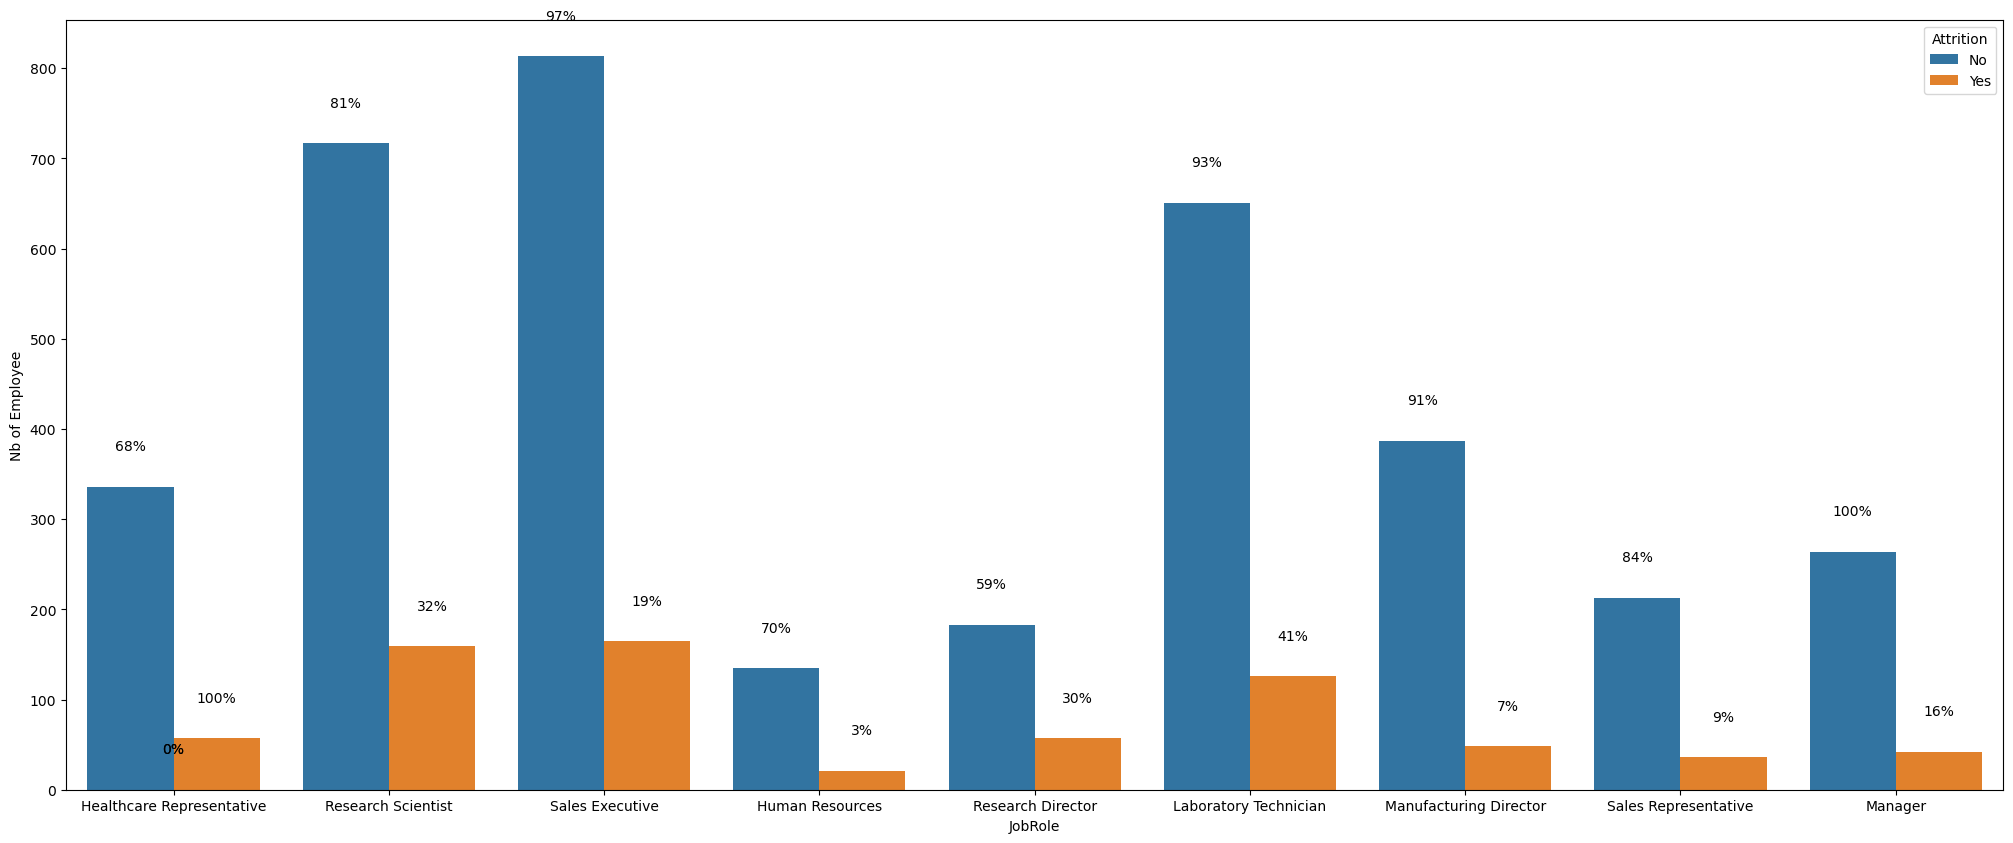

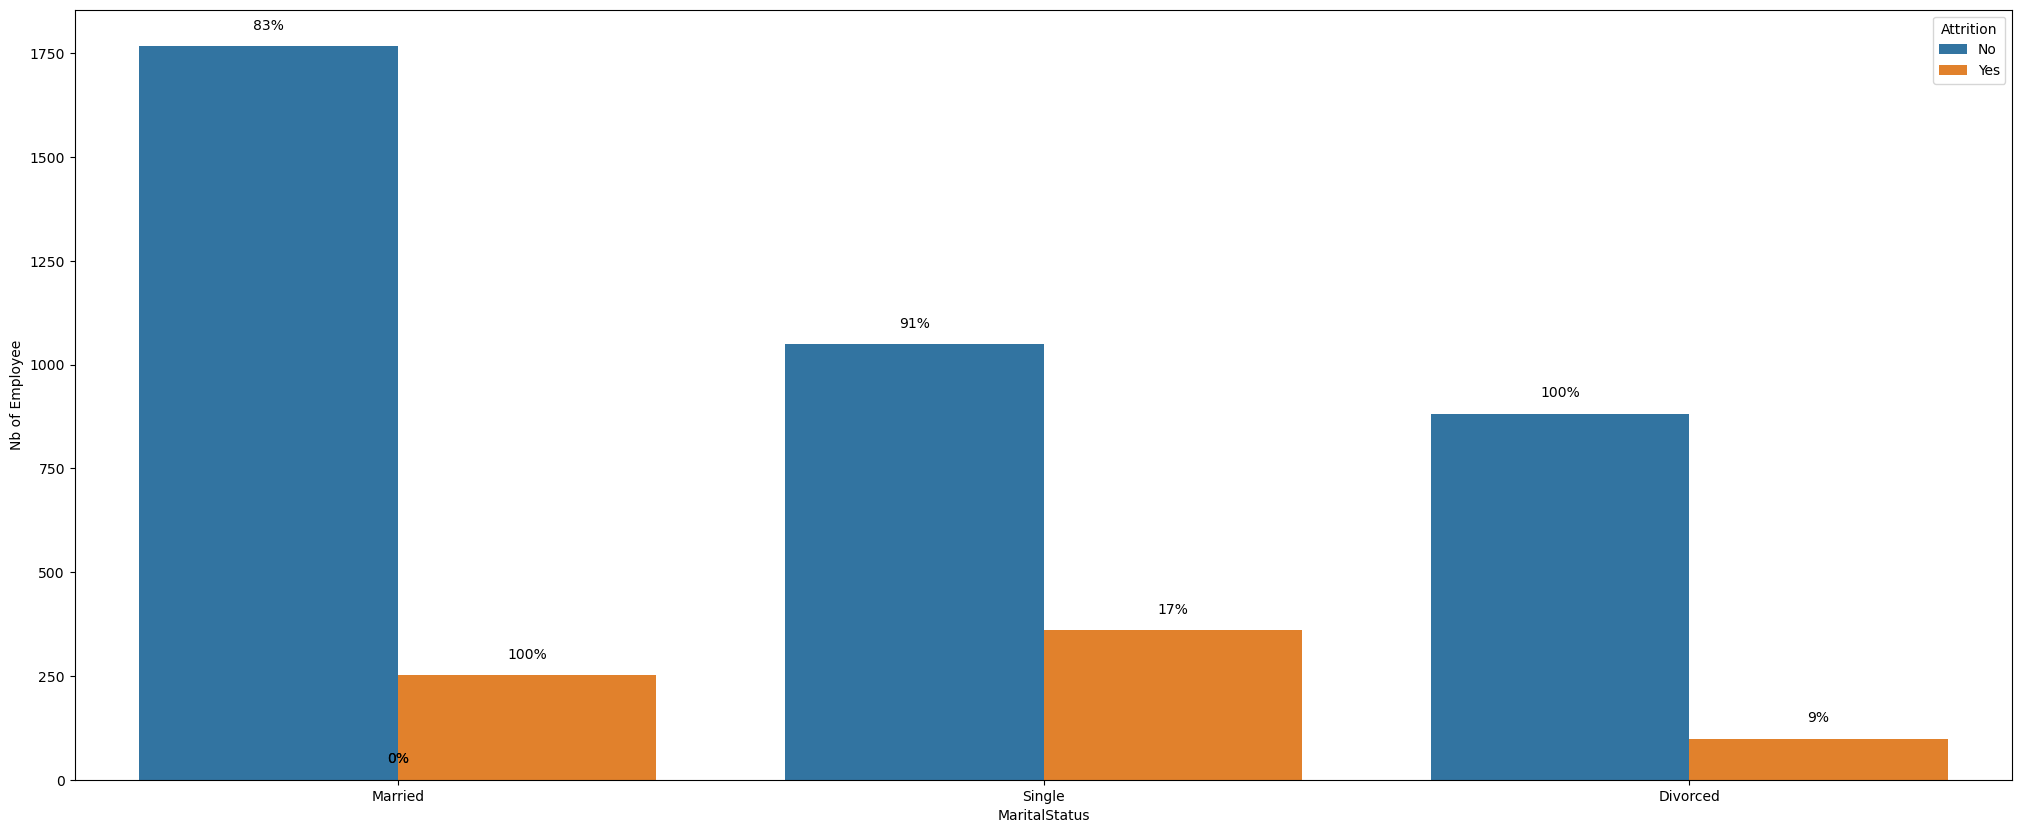

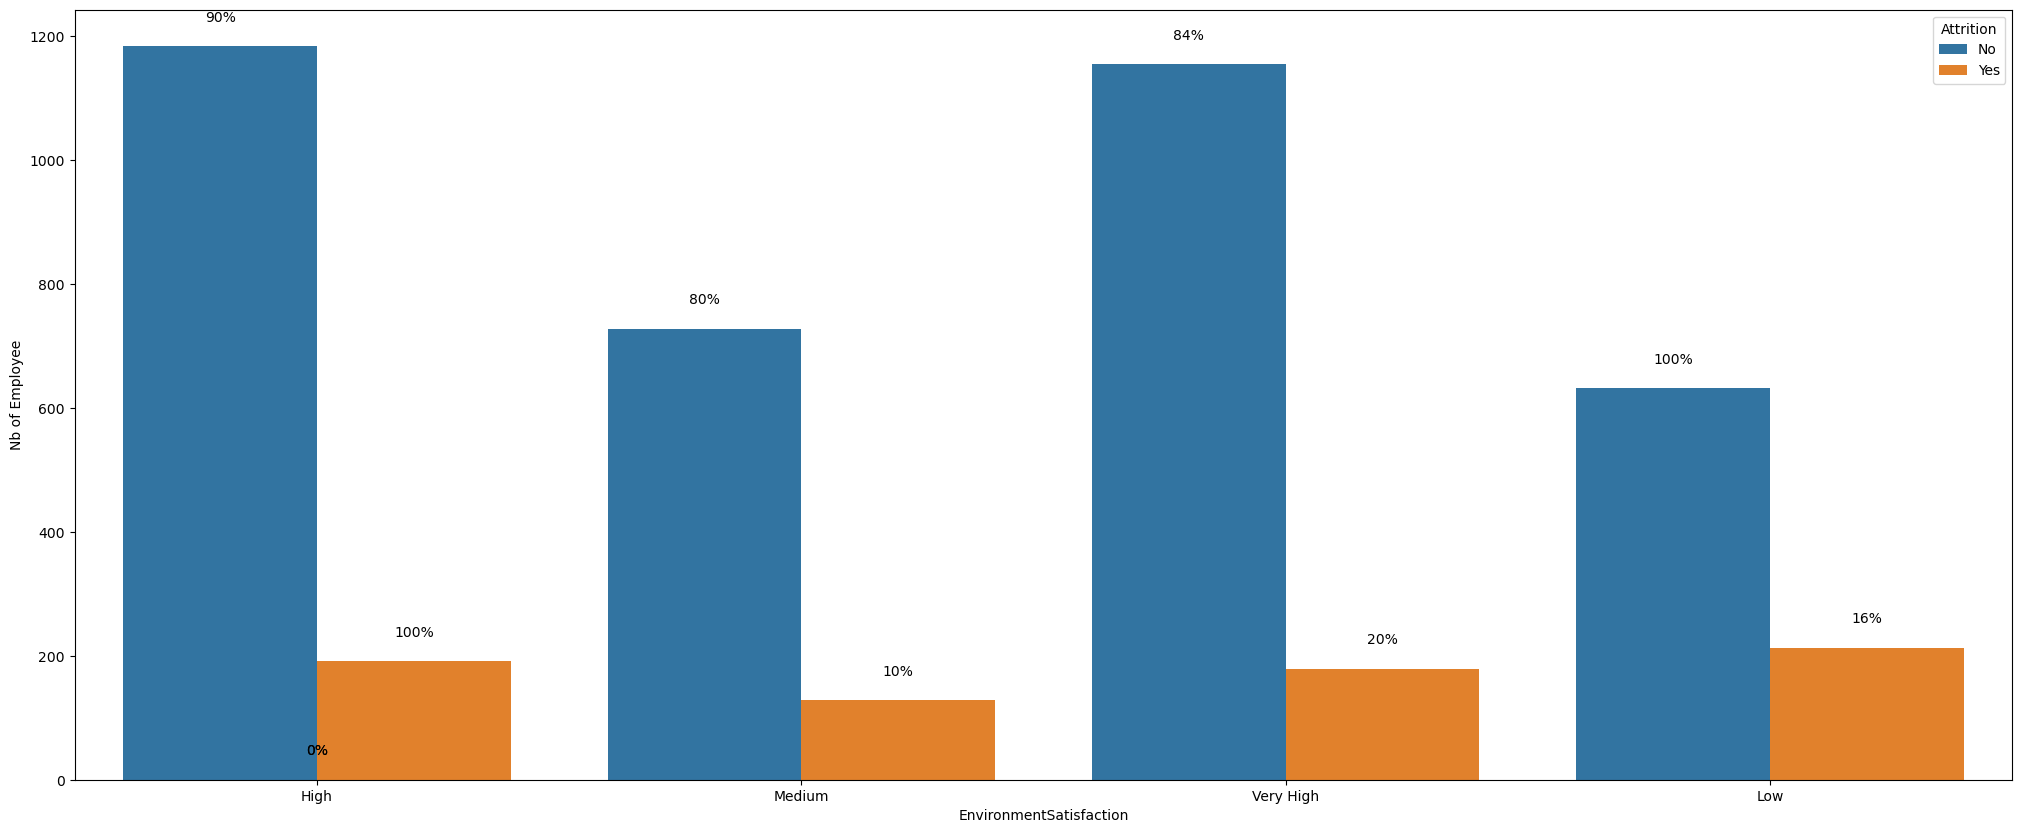

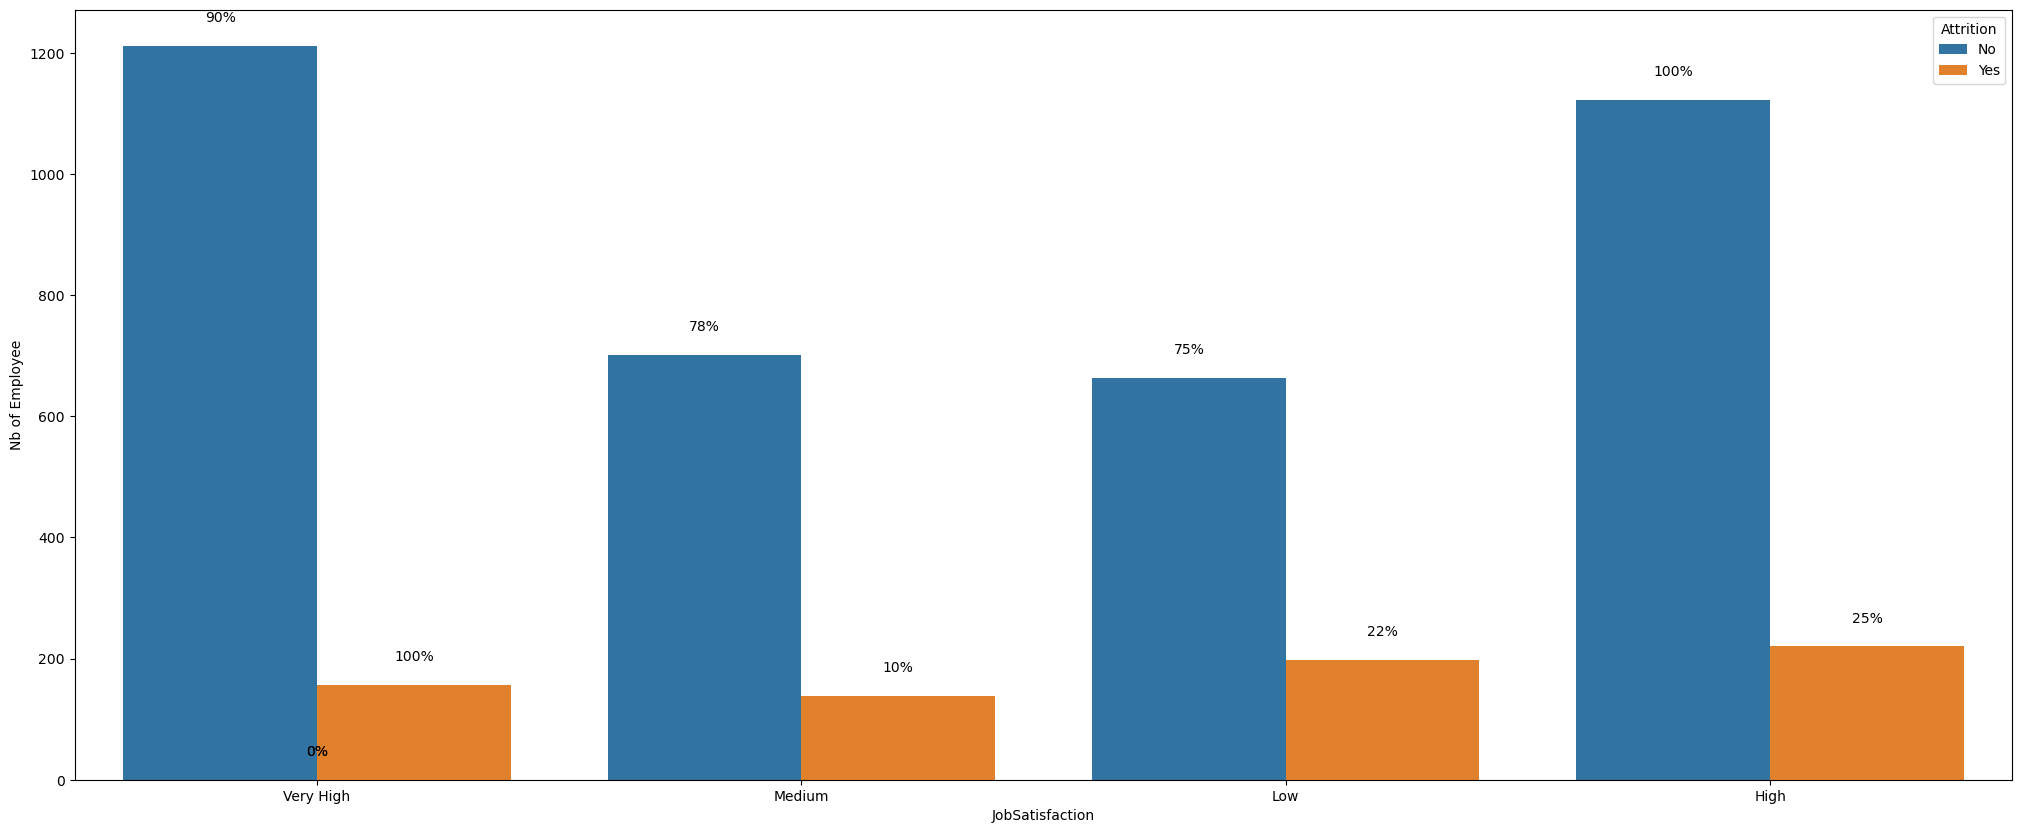

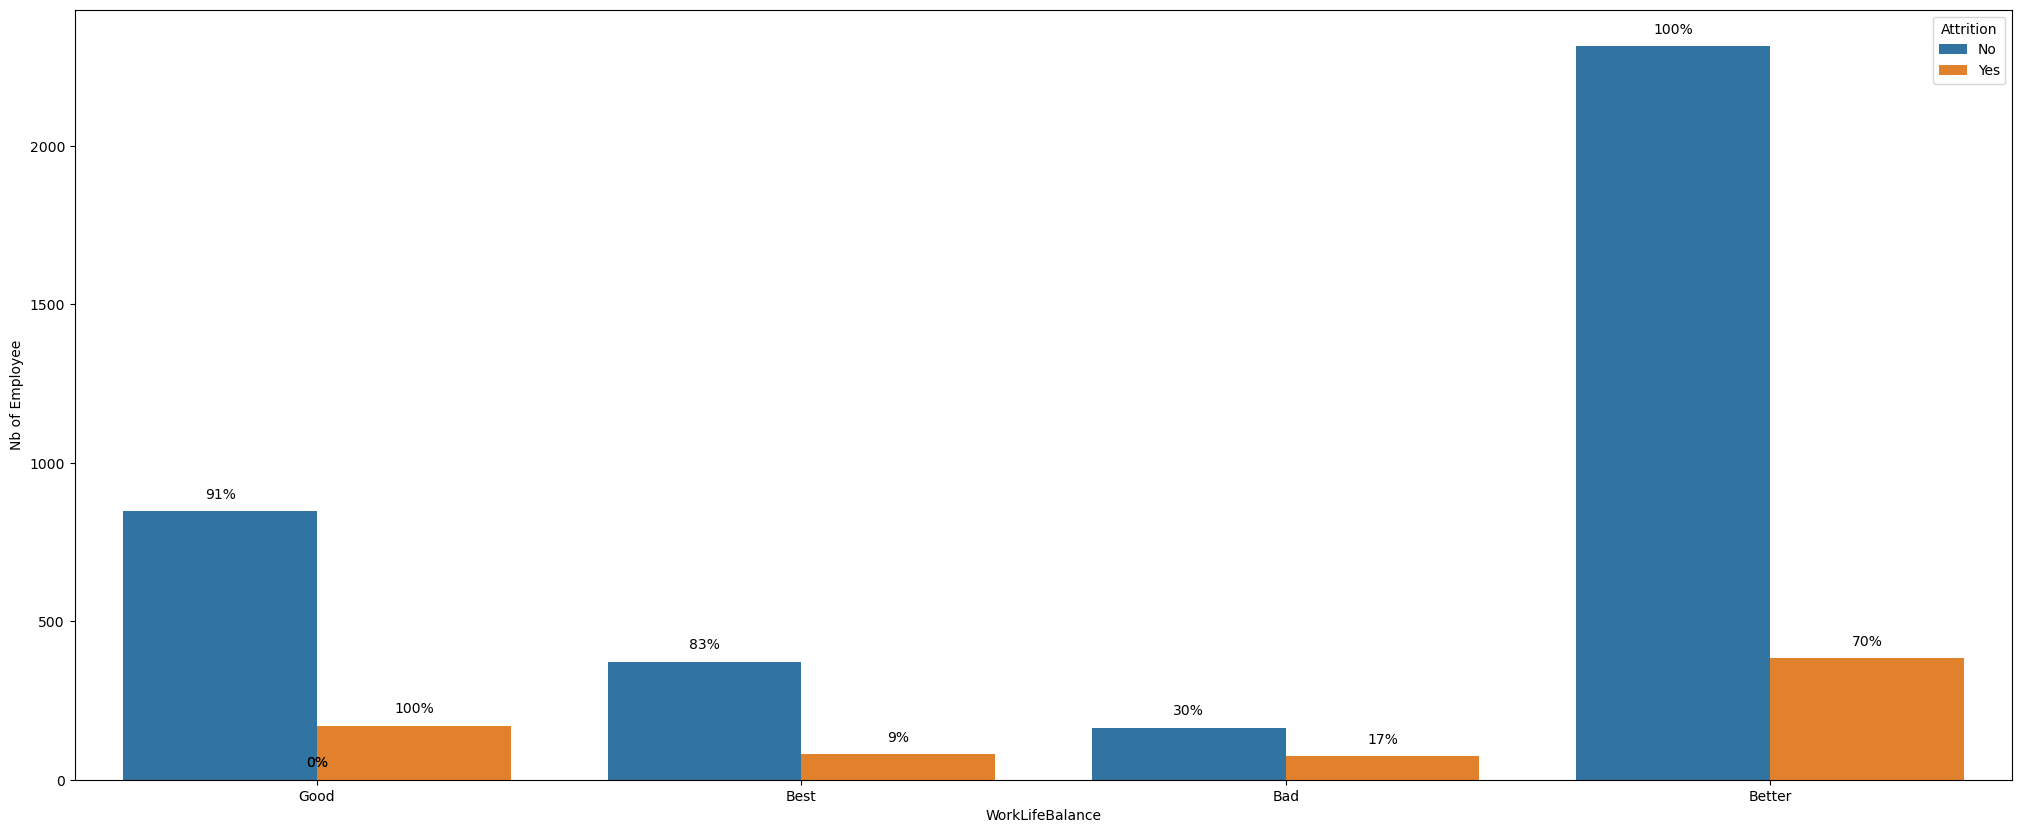

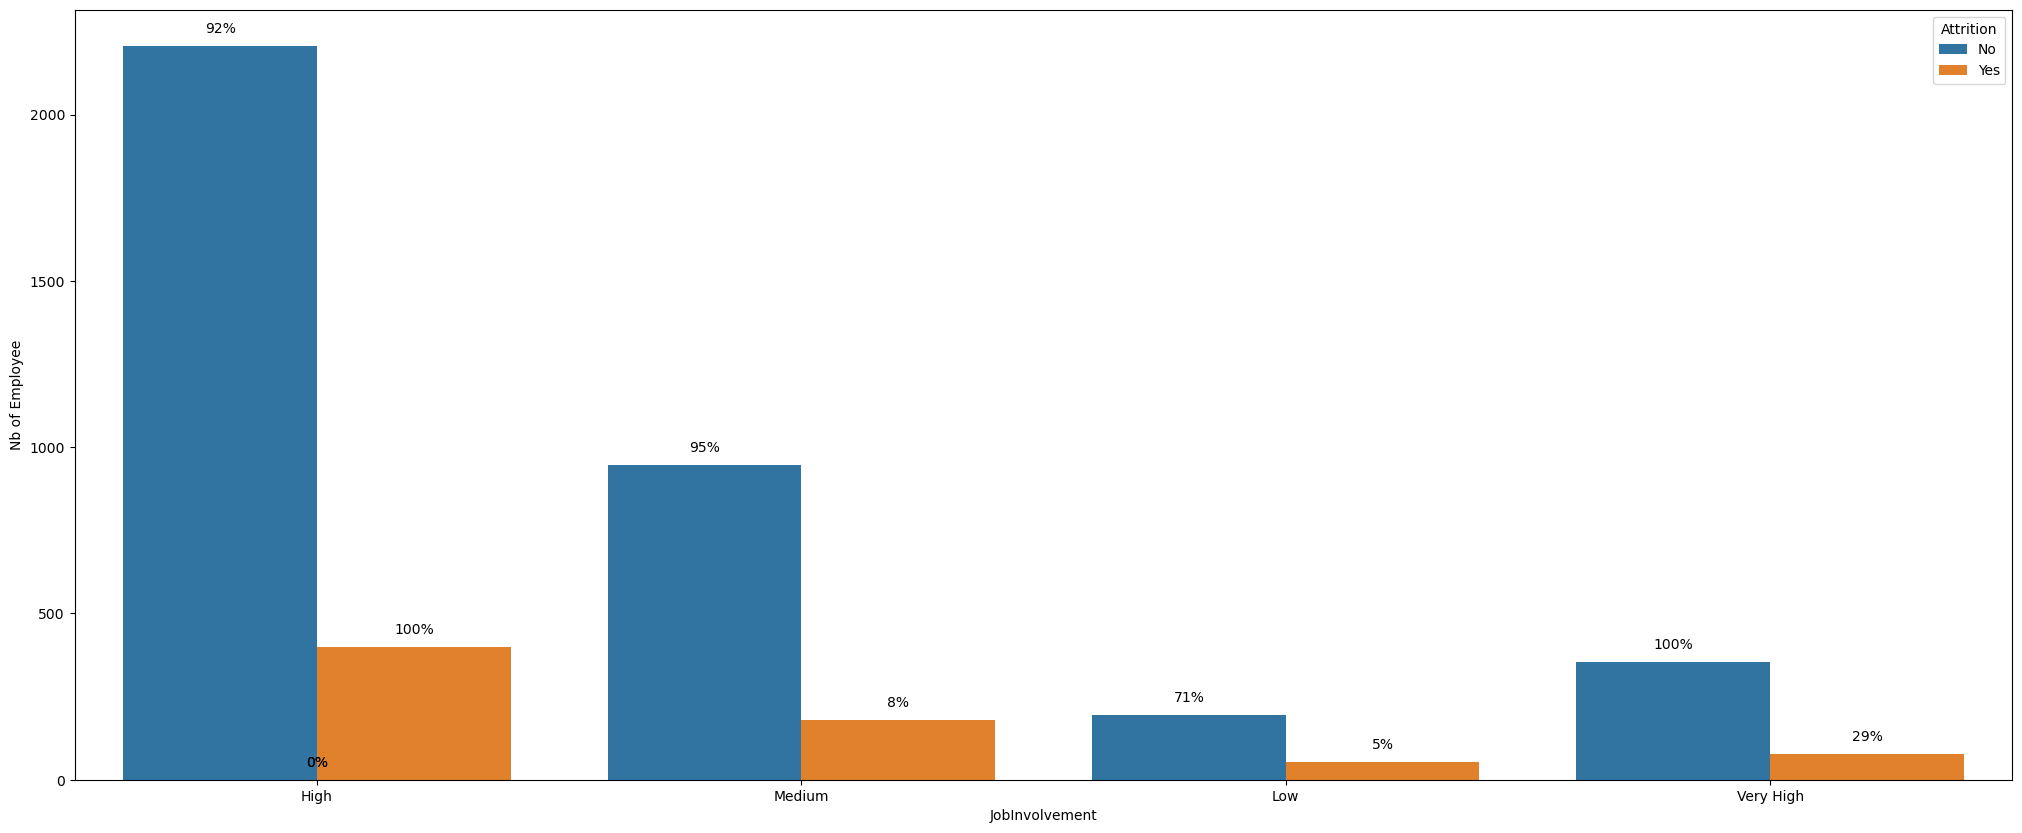

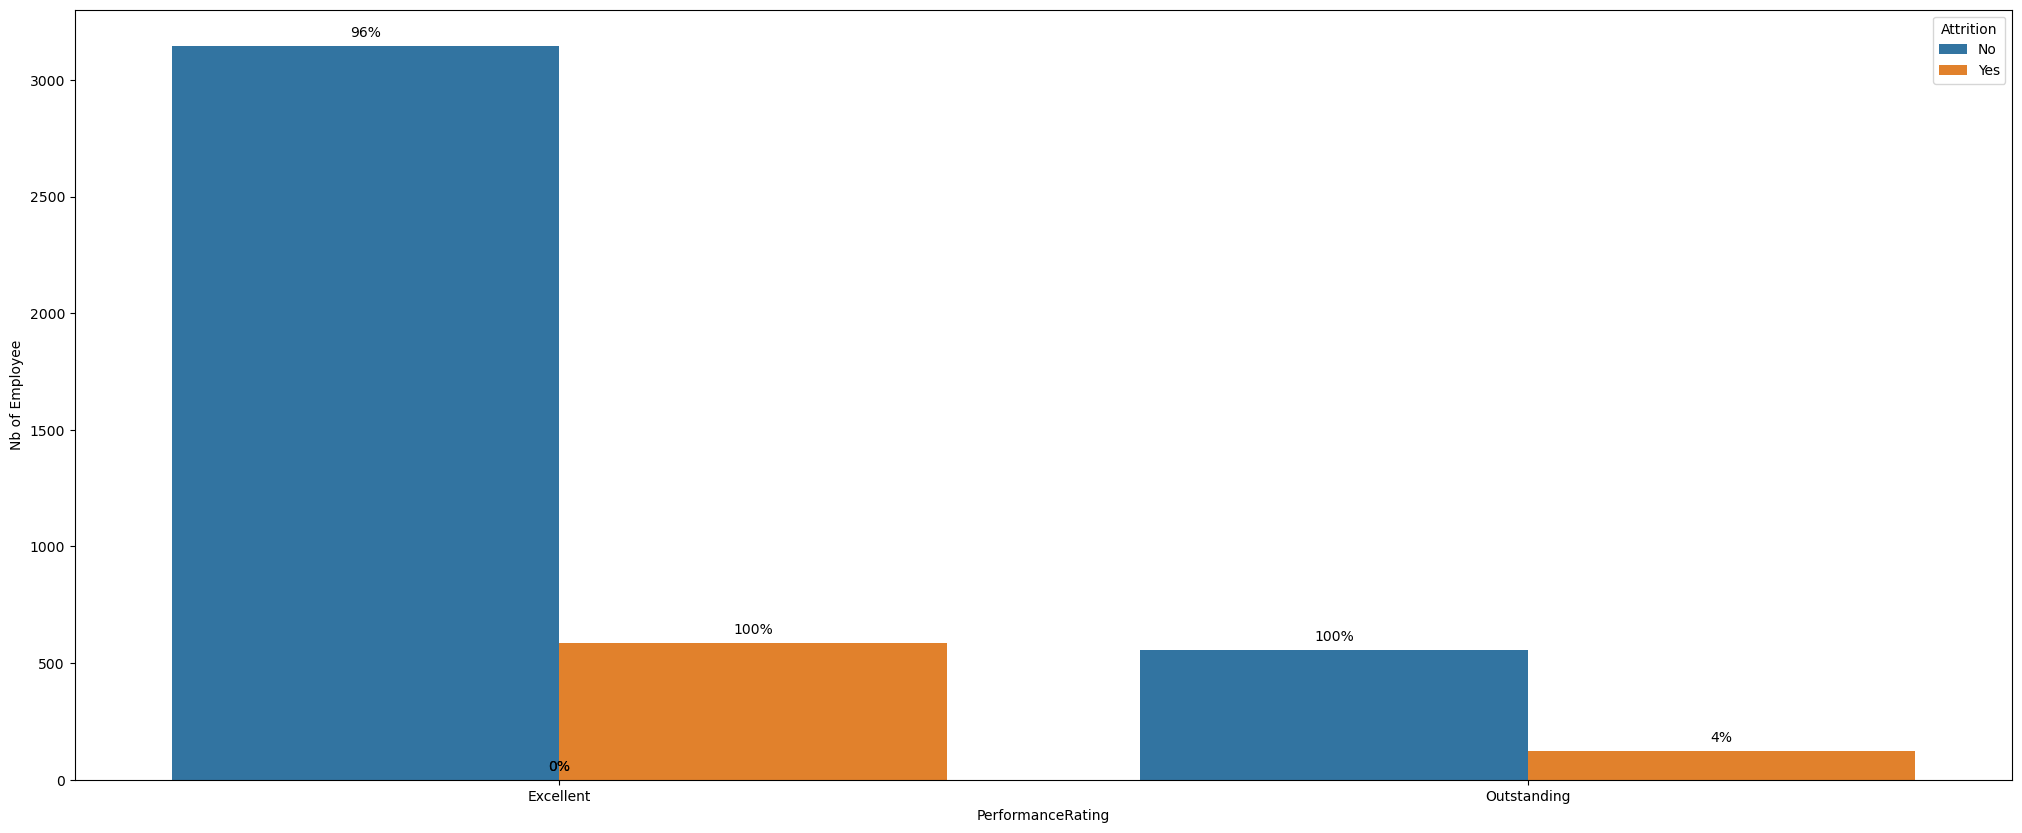

In [21]:
for name_column in general_data_copy.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        plt.figure(figsize=(25,10))
        ax = sns.countplot(x=name_column, data=general_data_copy, hue="Attrition")
        ax.set_ylabel('Nb of Employee')
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

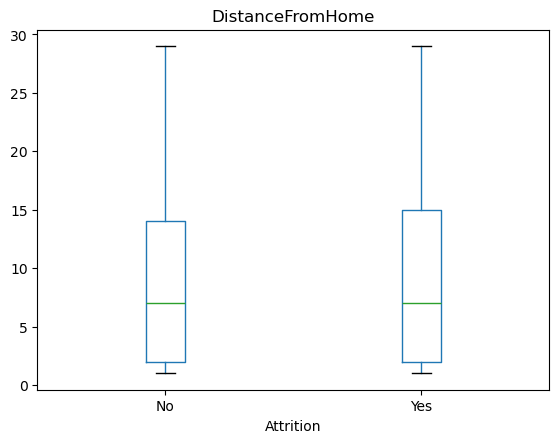

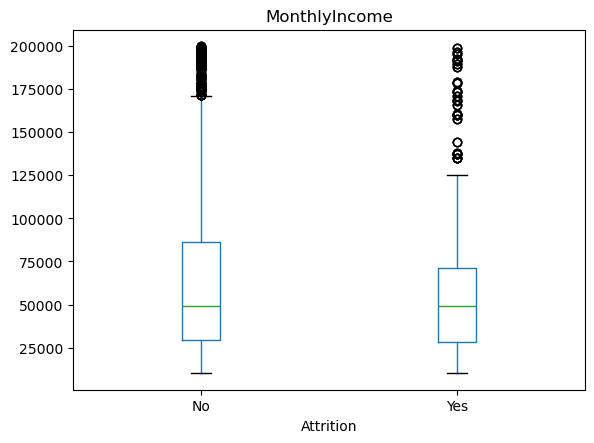

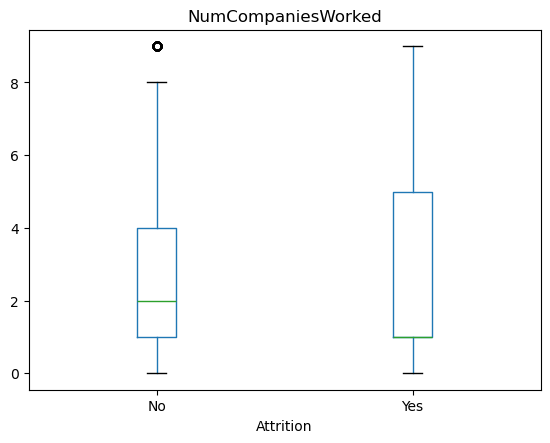

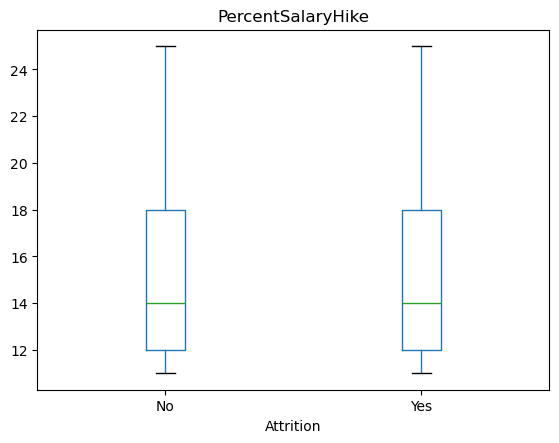

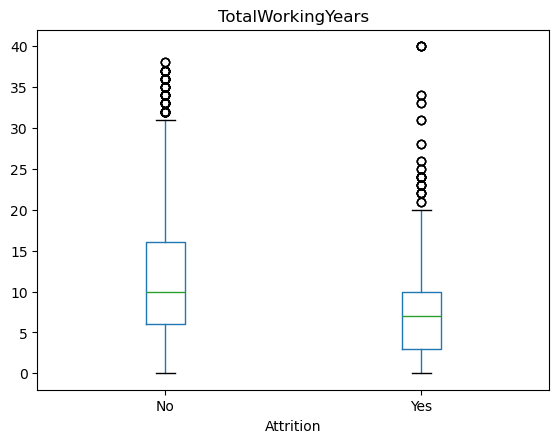

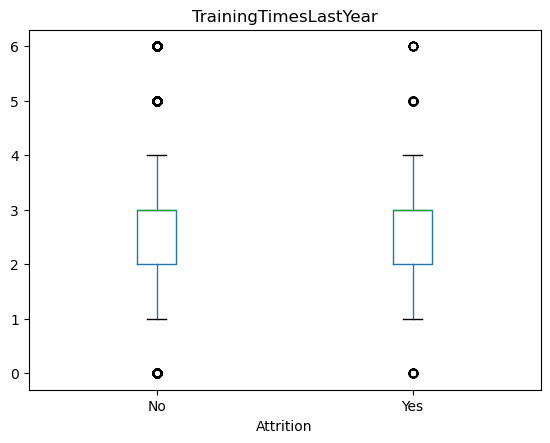

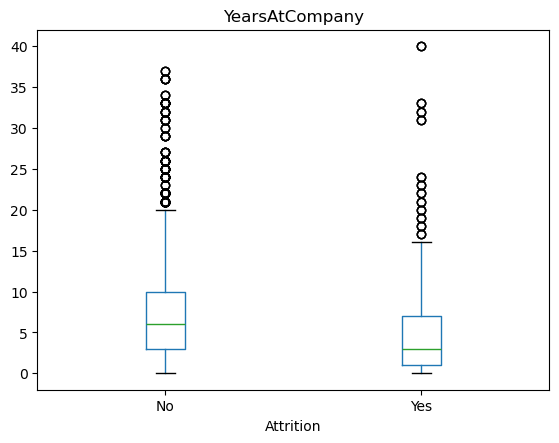

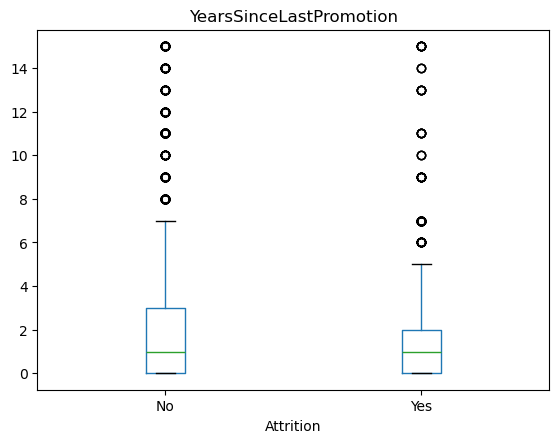

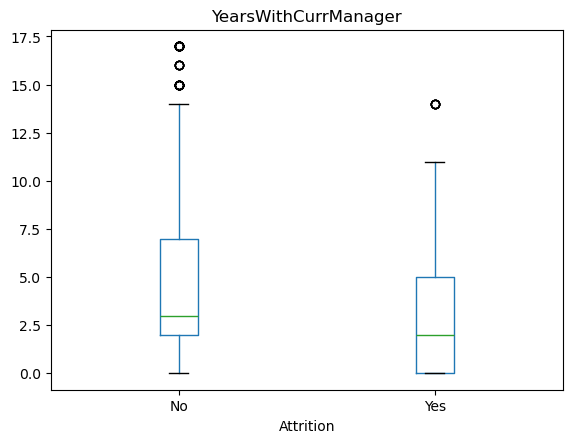

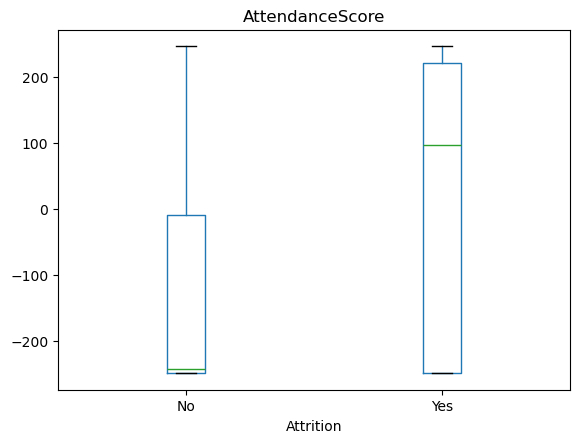

In [ ]:
for name_column in general_data_copy.select_dtypes(np.number).columns:
    general_data_copy.boxplot(by ='Attrition', column = name_column, grid = False, figsize=None) 
    plt.suptitle("")

Ces graphiques nous permettent d'émettre plusieurs théories, notamment:

1- Plus l'AttendanceScore de l'employé est élevé (plus il est présent au niveau horaire dans l'entreprise), plus il a de chahnces de quitter.
2- Si l'employé n'a pas d'expériences précédentes dans le milieu professionnel, il a plus de chances de quitter l'entreprise qu'un employé qui est dans le cas opposé (au moins une expérience précédente)
3- Les employés du département RH sont particulièrement suceptibles de quitter comparé aux autres départements. 
4- Les employés dont le salaire est inférieur à 125000 ont des chances plus élevées de quitter l'entreprise.

In [ ]:
#display the nurical data
non_numeric_columns = general_data_copy.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['Attrition', 'BusinessTravel', 'Department', 'Education',
       'EducationField', 'JobLevel', 'JobRole', 'MaritalStatus',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Reverse the encoding to restore original numerical values
general_data_copy['PerformanceRating'] = general_data_copy['PerformanceRating'].replace(
    {'Low': 1, 'Good': 2, 'Excellent': 3, 'Outstanding': 4}
)
general_data_copy['EnvironmentSatisfaction'] = general_data_copy['EnvironmentSatisfaction'].replace(
    {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
)
general_data_copy['JobSatisfaction'] = general_data_copy['JobSatisfaction'].replace(
    {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
)
general_data_copy['JobInvolvement'] = general_data_copy['JobInvolvement'].replace(
    {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
)
general_data_copy['WorkLifeBalance'] = general_data_copy['WorkLifeBalance'].replace(
    {'Bad': 1, 'Good': 2, 'Better': 3, 'Best': 4}
)
general_data_copy['Education'] = general_data_copy['Education'].replace(
    {'Below College': 1, 'College': 2, 'Bachelor': 3, 'Master': 4, 'Doctor': 5}
)
general_data_copy['JobLevel'] = general_data_copy['JobLevel'].replace(
    {'Apprentice': 1, 'Junior Employee': 2, 'Employee': 3, 'Manager': 4, 'Director': 5}
)
general_data_copy['Attrition'] = general_data_copy['Attrition'].replace(
    {'Yes': 1, 'No': 0}
)


label_encoder = LabelEncoder()
for col in non_numeric_columns:
    general_data_copy[col] = label_encoder.fit_transform(general_data_copy[col])




C:\Users\issam\AppData\Local\Temp\ipykernel_14560\1254654629.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  general_data_copy['PerformanceRating'] = general_data_copy['PerformanceRating'].replace(
C:\Users\issam\AppData\Local\Temp\ipykernel_14560\1254654629.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  general_data_copy['EnvironmentSatisfaction'] = general_data_copy['EnvironmentSatisfaction'].replace(
C:\Users\issam\AppData\Local\Temp\ipykernel_14560\1254654629.py:10: FutureWarning: Downcasting behavior in `replace` is 

La heatmap de corrélation permet d’analyser les relations entre les différentes variables du dataset en montrant la force et la direction des corrélations entre les colonnes.
Elle est utile pour détecter la redondance entre les variables et identifier les variables non informatives; repérer les relations cachées et réduire le bruit pour améliorer la généralisation

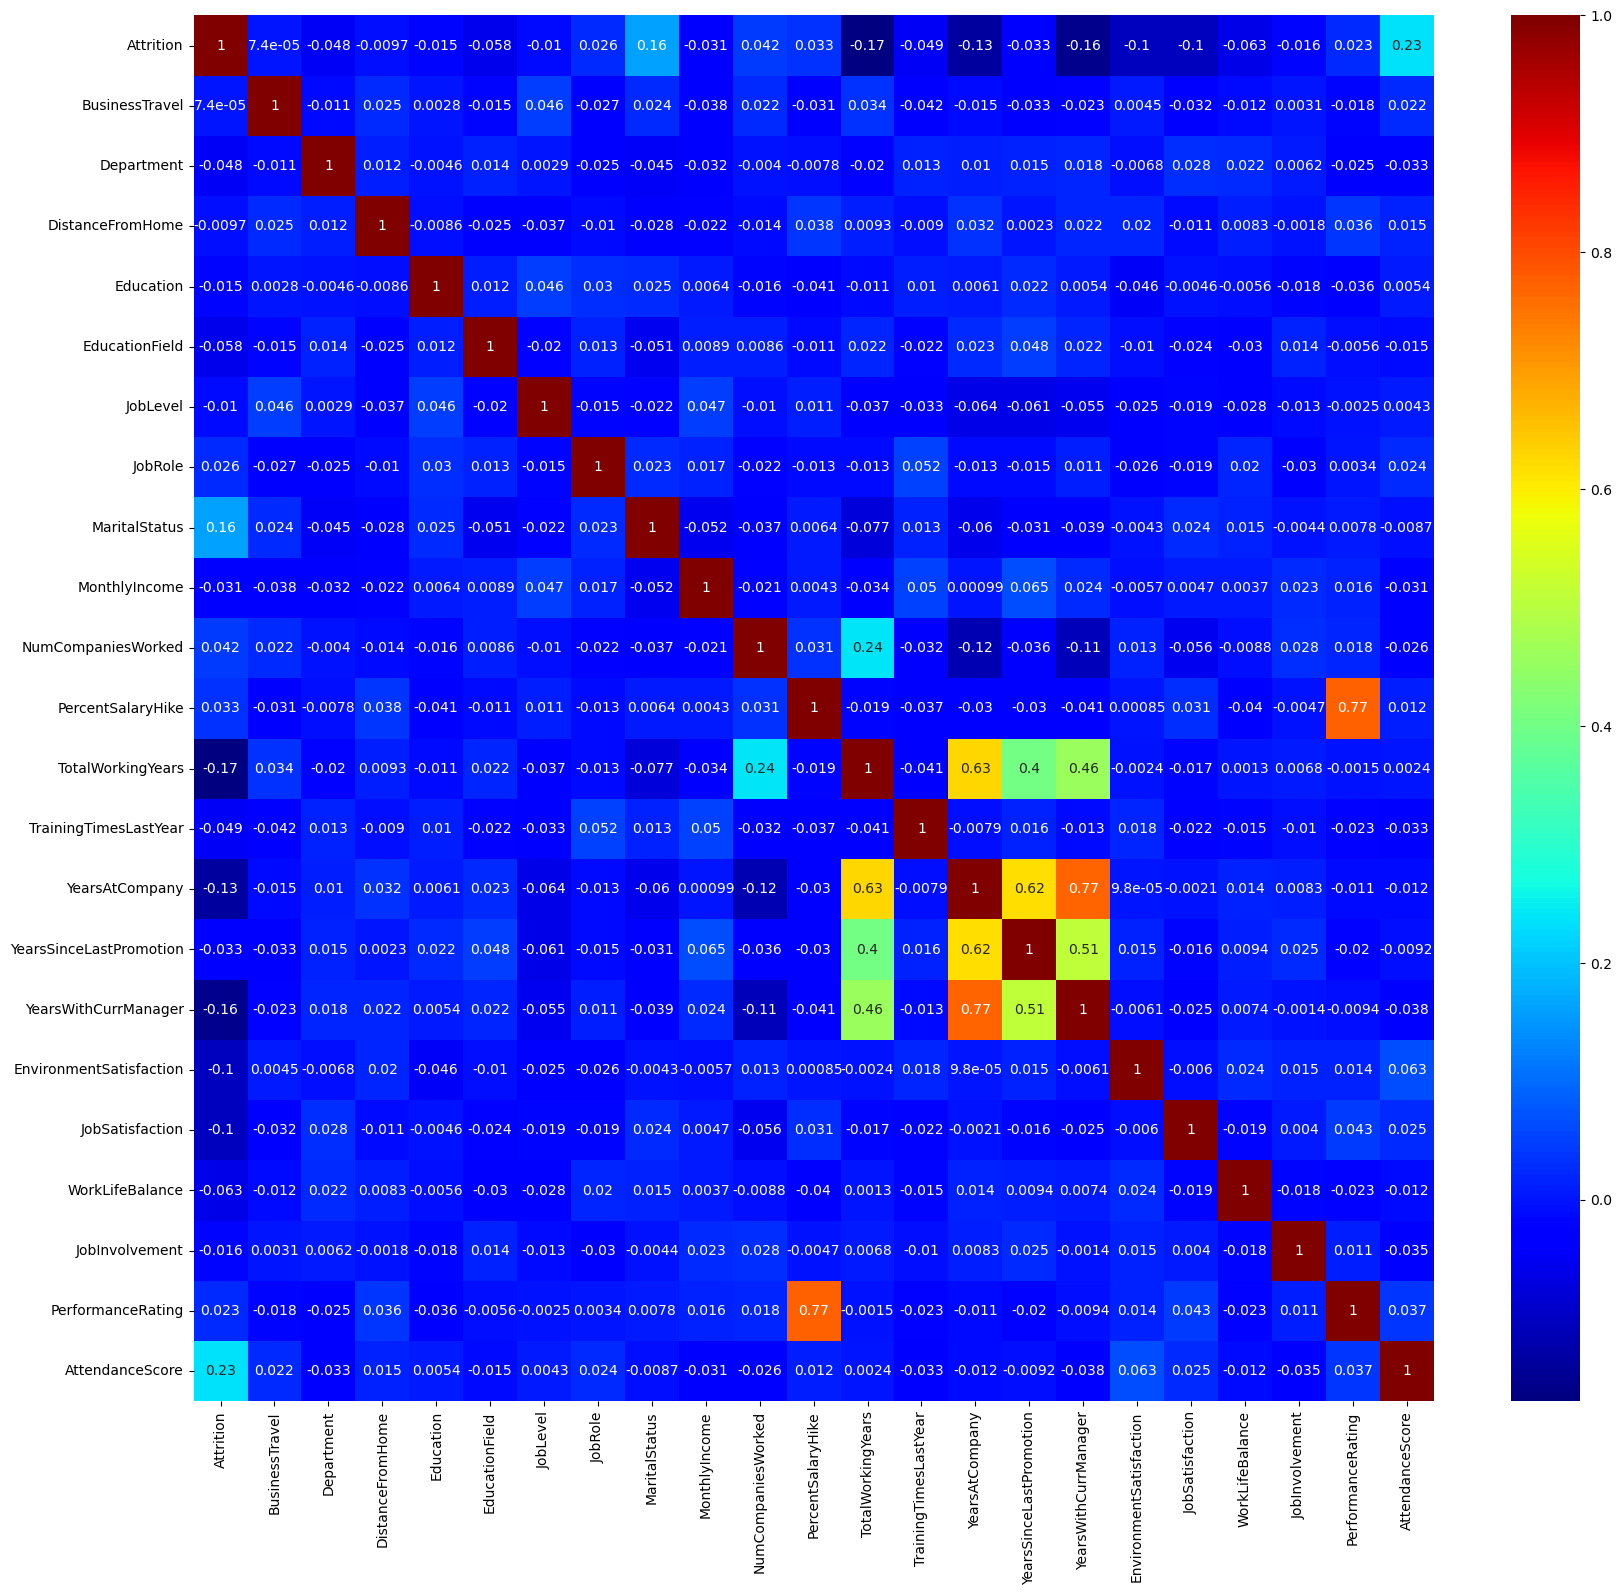

In [ ]:
#Display the heatmap to see the corelation between the data
corr_data = general_data_copy.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr_data, annot=True, cmap=plt.get_cmap("jet"))

plt.show()

In [ ]:
general_data_copy["PromotionFrequency"] = general_data_copy["YearsSinceLastPromotion"] / general_data_copy["TotalWorkingYears"]
general_data_copy.drop([ "MaritalStatus", "PercentSalaryHike"], axis=1, inplace=True)
general_data_copy.drop(["YearsAtCompany", "YearsWithCurrManager", "YearsSinceLastPromotion"], axis=1, inplace=True)


general_data_copy.head(10)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,TotalWorkingYears,TrainingTimesLastYear,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore,PromotionFrequency
0,0,2,2,6,1,1,0,0,131160,1.0,1.0,6,2,3,1,2,0,-249,0.000000
1,1,1,1,10,0,1,0,6,41890,0.0,6.0,3,2,1,3,1,1,-165,0.166667
2,0,1,1,17,3,4,3,7,193280,1.0,5.0,2,1,1,0,2,0,-249,0.000000
3,0,0,1,2,4,1,2,1,83210,3.0,13.0,5,3,3,2,1,0,-249,0.538462
4,0,2,1,10,0,3,0,7,23420,4.0,9.0,2,3,0,2,2,0,-19,0.000000
5,0,2,1,8,2,1,3,5,40710,3.0,28.0,5,2,1,1,2,0,225,0.250000
6,1,2,1,11,1,3,1,7,58130,2.0,5.0,2,0,2,0,2,1,-247,0.000000
7,0,2,1,18,2,1,1,7,31430,2.0,10.0,2,0,1,2,2,1,-249,0.000000
8,0,2,1,1,2,1,2,2,20440,0.0,10.0,2,1,3,2,2,1,-247,0.700000
9,0,0,1,7,3,3,3,2,134640,1.0,6.0,2,1,0,2,2,0,-249,0.166667


In [ ]:
general_data_copy.isnull().sum()

Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
JobLevel                    0
JobRole                     0
MonthlyIncome               0
NumCompaniesWorked          0
TotalWorkingYears           0
TrainingTimesLastYear       0
EnvironmentSatisfaction     0
JobSatisfaction             0
WorkLifeBalance             0
JobInvolvement              0
PerformanceRating           0
AttendanceScore             0
PromotionFrequency         33
dtype: int64

In [ ]:
general_data_copy["PromotionFrequency"].fillna(median, inplace=True)
general_data_copy.isnull().sum()

C:\Users\issam\AppData\Local\Temp\ipykernel_14560\2186688096.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  general_data_copy["PromotionFrequency"].fillna(median, inplace=True)


Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
JobLevel                   0
JobRole                    0
MonthlyIncome              0
NumCompaniesWorked         0
TotalWorkingYears          0
TrainingTimesLastYear      0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
AttendanceScore            0
PromotionFrequency         0
dtype: int64

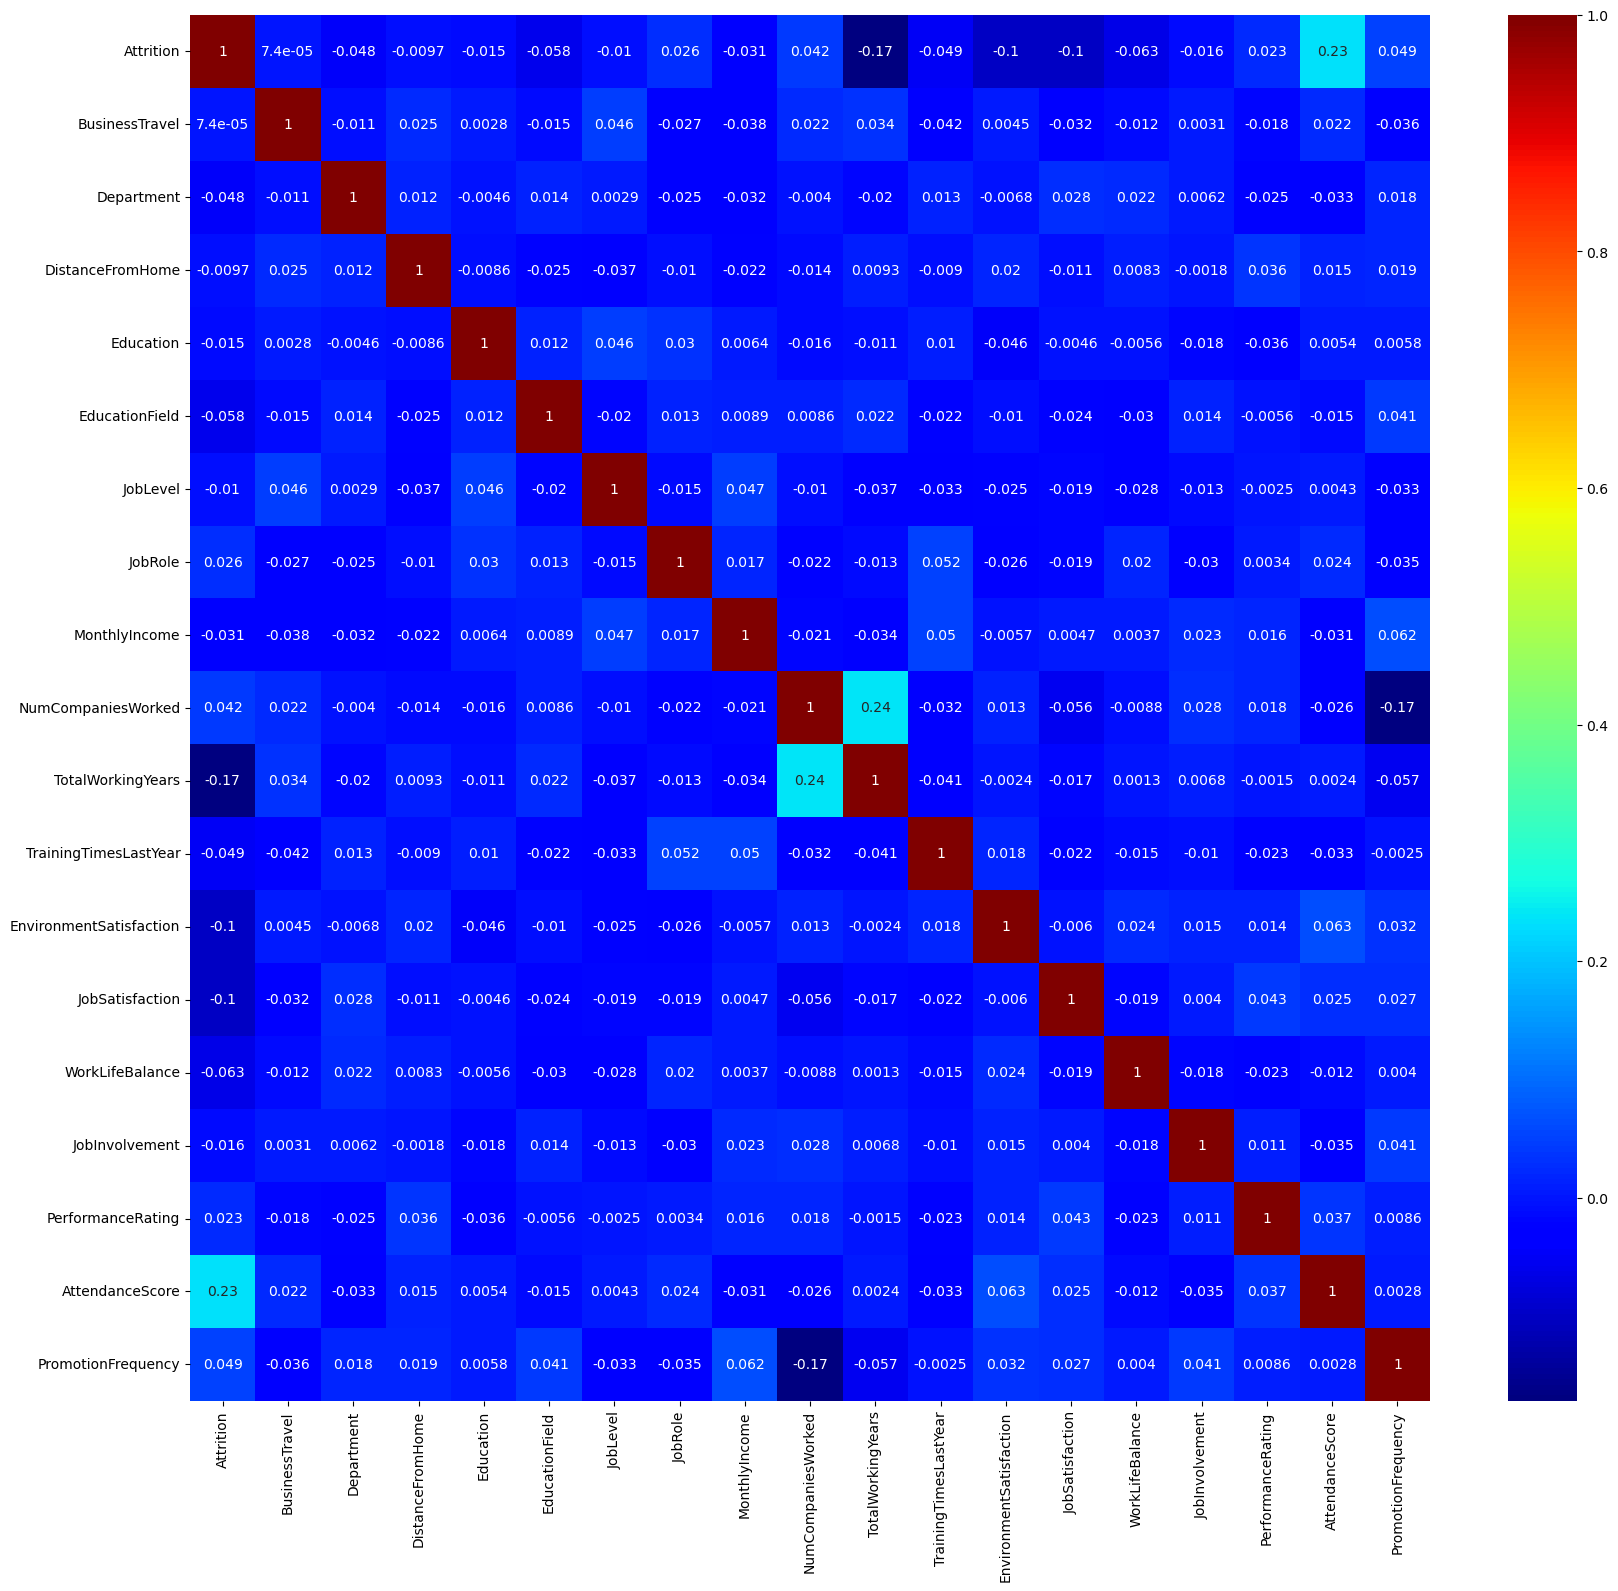

In [ ]:

corr_data = general_data_copy.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr_data, annot=True, cmap=plt.get_cmap("jet"))

plt.show()

In [ ]:
corr_data

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
Attrition,1.000000,0.000074,-0.048206,-0.009730,-0.015111,-0.057940,-0.010290,0.025809,0.162070,-0.031176,...,-0.049431,-0.134392,-0.033019,-0.156199,-0.101625,-0.103068,-0.062975,-0.015588,0.023403,0.233609
BusinessTravel,0.000074,1.000000,-0.010982,0.024616,0.002755,-0.015462,0.046111,-0.027194,0.024001,-0.037597,...,-0.041888,-0.014575,-0.032591,-0.022636,0.004464,-0.032038,-0.011821,0.003121,-0.017836,0.021895
Department,-0.048206,-0.010982,1.000000,0.012134,-0.004597,0.013720,0.002923,-0.025466,-0.044619,-0.032237,...,0.012866,0.010078,0.014845,0.018016,-0.006792,0.028487,0.021840,0.006228,-0.024604,-0.032918
DistanceFromHome,-0.009730,0.024616,0.012134,1.000000,-0.008638,-0.024665,-0.037329,-0.010293,-0.027893,-0.021607,...,-0.009001,0.031684,0.002290,0.021584,0.020113,-0.011213,0.008305,-0.001837,0.036418,0.014932
Education,-0.015111,0.002755,-0.004597,-0.008638,1.000000,0.012329,0.045746,0.030155,0.024991,0.006410,...,0.010472,0.006080,0.022490,0.005358,-0.045636,-0.004612,-0.005610,-0.018279,-0.035591,0.005354
EducationField,-0.057940,-0.015462,0.013720,-0.024665,0.012329,1.000000,-0.019528,0.013106,-0.051409,0.008858,...,-0.021793,0.023120,0.048181,0.021664,-0.009988,-0.023661,-0.030210,0.013872,-0.005614,-0.014713
JobLevel,-0.010290,0.046111,0.002923,-0.037329,0.045746,-0.019528,1.000000,-0.014763,-0.022021,0.047316,...,-0.032500,-0.064219,-0.060811,-0.055251,-0.024540,-0.018596,-0.027763,-0.012630,-0.002474,0.004321
JobRole,0.025809,-0.027194,-0.025466,-0.010293,0.030155,0.013106,-0.014763,1.000000,0.022888,0.017072,...,0.051744,-0.012886,-0.014635,0.010695,-0.026068,-0.019036,0.020331,-0.029524,0.003355,0.024022
MaritalStatus,0.162070,0.024001,-0.044619,-0.027893,0.024991,-0.051409,-0.022021,0.022888,1.000000,-0.052383,...,0.012798,-0.059986,-0.030915,-0.038570,-0.004304,0.023766,0.014778,-0.004429,0.007791,-0.008719
MonthlyIncome,-0.031176,-0.037597,-0.032237,-0.021607,0.006410,0.008858,0.047316,0.017072,-0.052383,1.000000,...,0.050112,0.000995,0.065219,0.024304,-0.005747,0.004716,0.003705,0.023346,0.016093,-0.031496


## Sélection des caractéristiques : Suppression des colonnes non corrélées dans la heatmap
Dans la matrice de corrélation, certaines colonnes ont été identifiées comme n’ayant que peu ou pas de corrélation avec les autres variables. Ces colonnes sont supprimées afin d’éviter d’inclure trop de paramètres non pertinents dans le modèle, ce qui permet d’obtenir des résultats plus fiables et d’améliorer les performances prédictives.

Les colonnes suivantes ont été éliminées en raison de leur faible corrélation avec les autres caractéristiques :

BusinessTravel

Department

DistanceFromHome

Education

EducationField

EmployeeID

JobLevel

JobRole

MonthlyIncome

StockOptionLevel

TrainingTimesLastYear

JobSatisfaction

WorkLifeBalance

JobInvolvement

La fonction separation_significant_parameters est appliquée à la matrice de corrélation (corr_data) afin de séparer les paramètres significatifs de ceux jugés insignifiants.


In [ ]:
# Categorizes DataFrame columns into significant and insignificant parameters based on their maximum absolute correlation with other columns.
def separation_significant_parameters(frame, threshold=0.1):  
    insignificant_parameters = []
    significant_parameters = []

    for col in frame.columns:
        # Get maximum absolute correlation excluding self-correlation (diagonal = 1)
        max_correlation = frame[col].drop(col).abs().max()
        
        if max_correlation < threshold:
            insignificant_parameters.append(col)
        else:
            significant_parameters.append(col)

    return significant_parameters, insignificant_parameters
# Modifies the DataFrame by setting values close to zero (between -0.1 and 0.1) to exactly 0.

def retain_terminal(frame):
    for i in frame.keys():
        for a in range(len(frame[i])):
            if frame[i][a] > 0.1 or frame[i][a] < -0.1:
                frame[i][a] = frame[i][a]
            else:
                frame[i][a] = 0
    return frame

In [ ]:


significant_parameter, insignificant_parameter = separation_significant_parameters(corr_data)


### Conclusion et Interprétation des Résultats
Le modèle optimal est sélectionné en fonction des scores obtenus sur les données de test. L'importance de chaque hyperparamètre est analysée pour comprendre son impact sur les performances. Enfin, les résultats sont interprétés en fonction du contexte des données utilisées et des limitations éventuelles.

C:\Users\issam\AppData\Local\Temp\ipykernel_14560\3652800369.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if frame[i][a] > 0.1 or frame[i][a] < -0.1:
C:\Users\issam\AppData\Local\Temp\ipykernel_14560\3652800369.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frame[i][a] = frame[i][a]
C:\Users\issam\AppData\Local\Temp\ipykernel_14560\3652800369.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this wi

<Axes: >

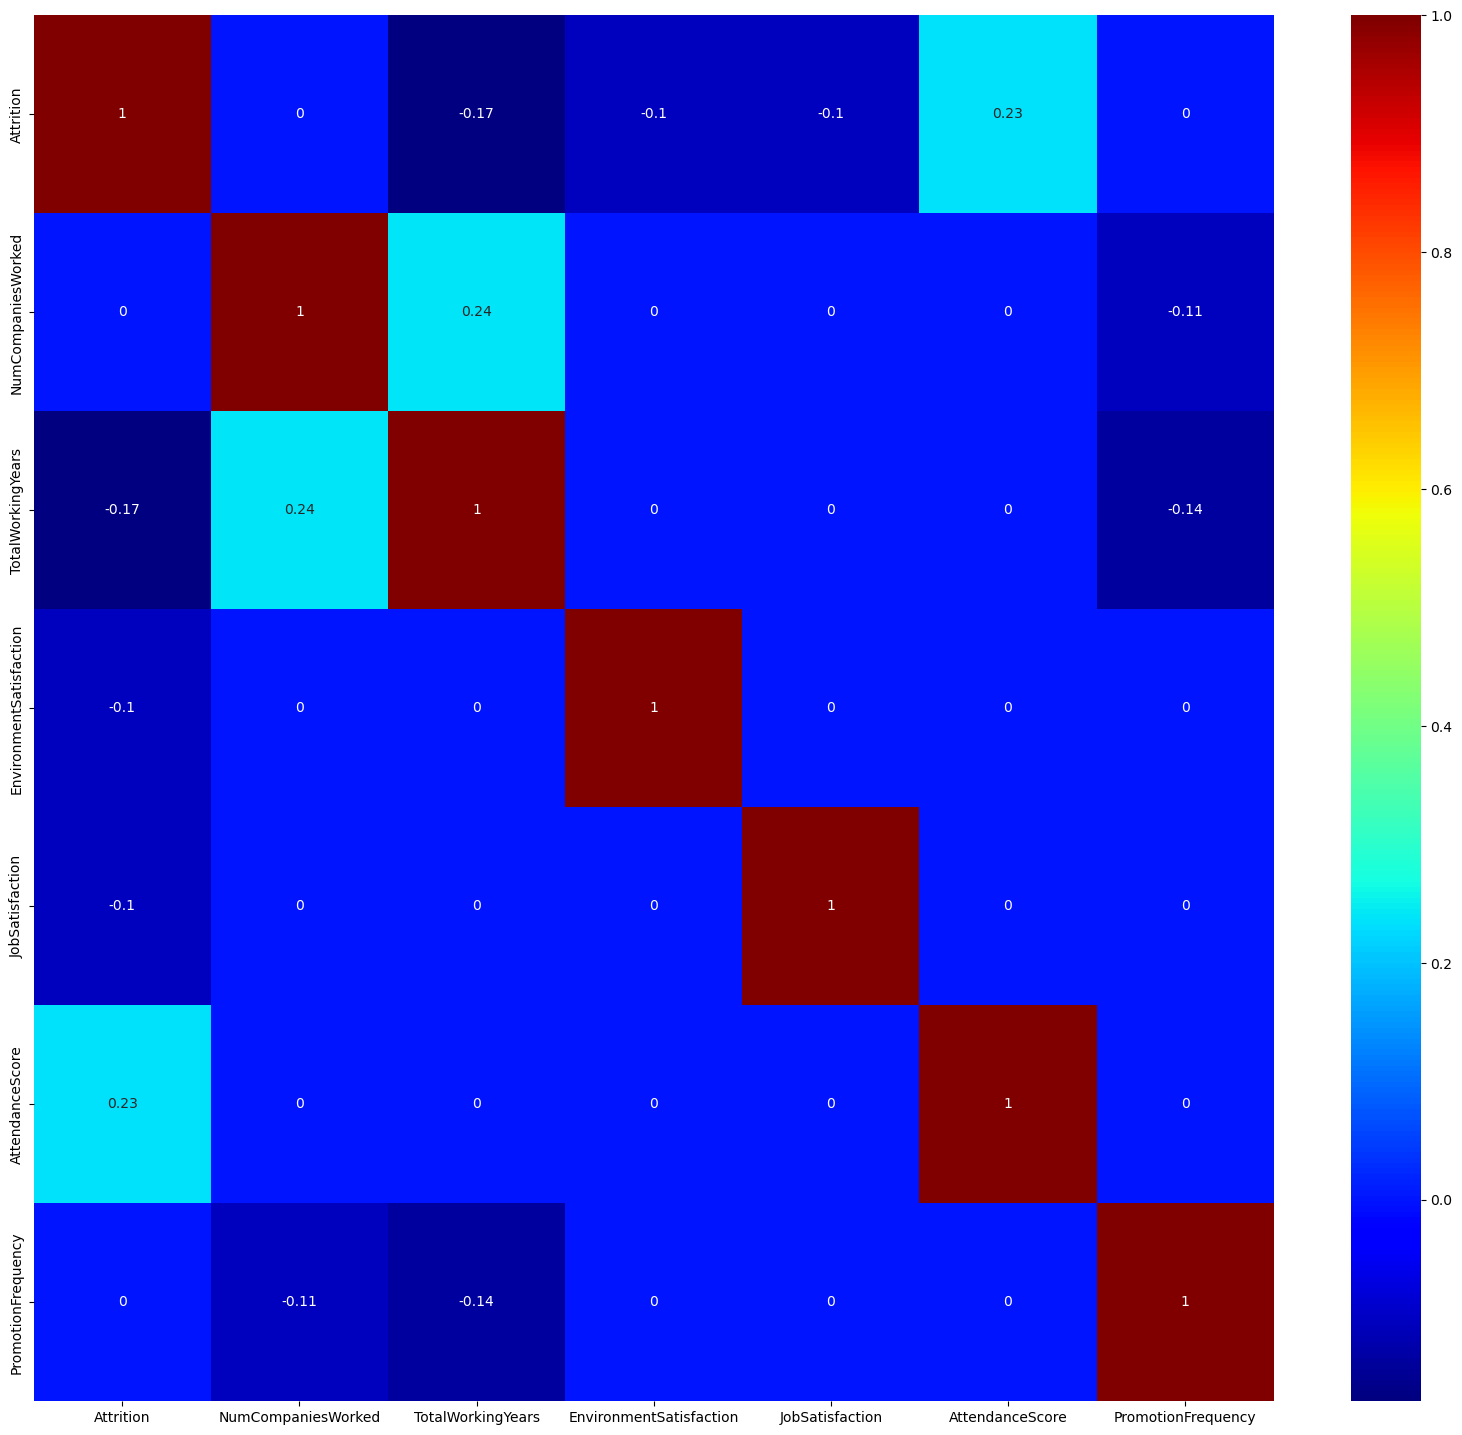

In [ ]:
# Display the heatmap with the most imprortant data

corr_tmp = general_data_copy[significant_parameter].corr()
corr_tmp = retain_terminal(corr_tmp)

plt.figure(figsize=(20,18))
sns.heatmap(corr_tmp, annot = True, cmap=plt.get_cmap("jet"))


La heatmap met en évidence les relations entre différentes variables du dataset.
Un groupe de variables fortement corrélées (TotalWorkingYears, YearsAtCompany, YearsWithCurrManager, YearsSinceLastPromotion) montre une interdépendance entre l’ancienneté et la stabilité dans l’entreprise.
Il pourrait être utile d'évaluer l'importance des variables pour confirmer celles qui ont réellement un impact significatif sur l'attrition

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Select features (X) and target variable (y) from the dataset
X = general_data_copy.iloc[:, [1] + list(range(2, general_data_copy.shape[1]))] # All columns except the first one (features)

y = general_data_copy.iloc[:, 0] # The first column (target variable)

# Create a StratifiedShuffleSplit object for splitting the dataset while maintaining class distribution
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in stratified_split.split(X, y):

    # Split the data into training and testing sets based on the generated indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train.head()


,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,TotalWorkingYears,TrainingTimesLastYear,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore,PromotionFrequency
3465,2,2,1,3,1,0,5,52570,1.0,10.0,2,1,2,2,3,0,-81,0.0
3485,0,2,1,0,2,1,5,26960,3.0,6.0,3,2,3,2,2,1,-249,0.0
3052,2,0,10,1,0,0,2,53730,1.0,1.0,2,2,1,2,2,0,-249,0.0
2012,1,1,7,2,1,1,3,29760,1.0,1.0,3,0,1,2,2,0,-249,0.0
426,2,1,1,3,3,1,6,192320,2.0,11.0,3,0,1,1,2,0,-249,0.0


### Comparaison des modèles
Nous utilisons `GridSearchCV` pour ajuster automatiquement les hyperparamètres des modèles et sélectionner le meilleur. Les modèles testés incluent :
- **Régression Logistique** : efficace pour des problèmes linéaires
- **SVM** : adapté aux données non linéaires
- **Arbres de Décision** : interprétables mais sensibles au surapprentissage
- **Forêt Aléatoire** : robuste et performant
- **Naïve Bayes** : utile pour les données avec des hypothèses d'indépendance
- **Perceptron** : simple réseau de neurones

Nous comparons les modèles sur leurs performances (accuracy, F1-score) et sélectionnons celui qui offre les meilleurs résultats.

c:\Users\issam\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\issam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\issam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi


Logistic Regression:
Accuracy: 0.8458

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       741
           1       0.62      0.09      0.16       141

    accuracy                           0.85       882
   macro avg       0.74      0.54      0.54       882
weighted avg       0.81      0.85      0.79       882


Perceptron:
Accuracy: 0.8401

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       741
           1       0.00      0.00      0.00       141

    accuracy                           0.84       882
   macro avg       0.42      0.50      0.46       882
weighted avg       0.71      0.84      0.77       882


Gaussian NB:
Accuracy: 0.8401

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       741
           1       0.50      0.02      0.04       141

    accura

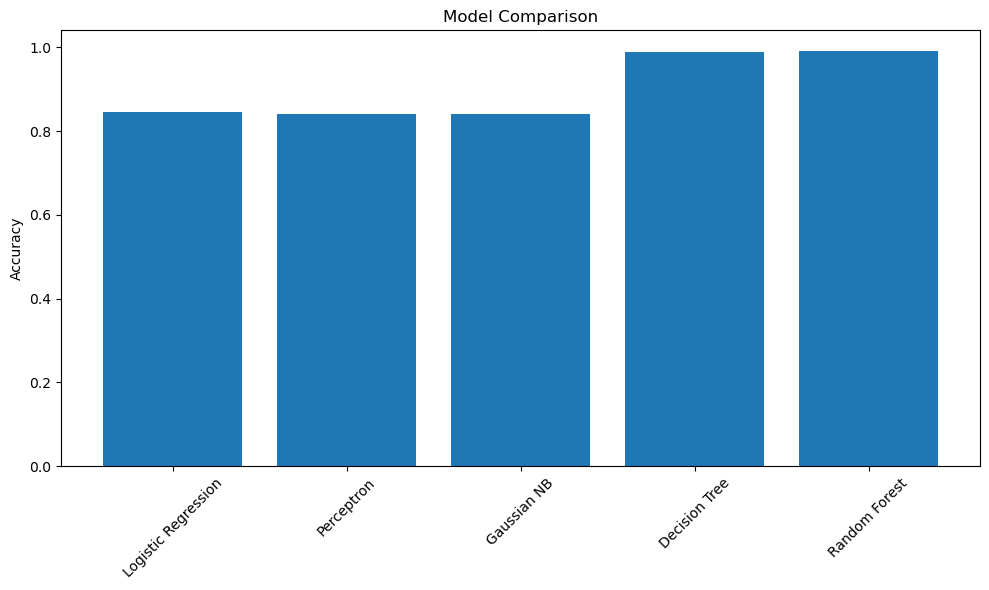

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Create a dictionary of models
models = {
    'Logistic Regression': LogisticRegression(),
    'Perceptron': Perceptron(),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f'\n{name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.tight_layout()
plt.show()


Training Logistic Regression...

Training Decision Tree...

Training Random Forest...


c:\Users\issam\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\issam\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\issam\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\issam\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\issam\anaconda3\Lib\site-package


Training Gaussian NB...

Training Perceptron...

Logistic Regression:
Best Score: 0.8489
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Decision Tree:
Best Score: 0.9328
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

Random Forest:
Best Score: 0.9867
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Gaussian NB:
Best Score: 0.8401
Best Parameters: {'var_smoothing': 1e-09}

Perceptron:
Best Score: 0.7710
Best Parameters: {'alpha': 0.0001, 'max_iter': 1000, 'penalty': 'l2'}


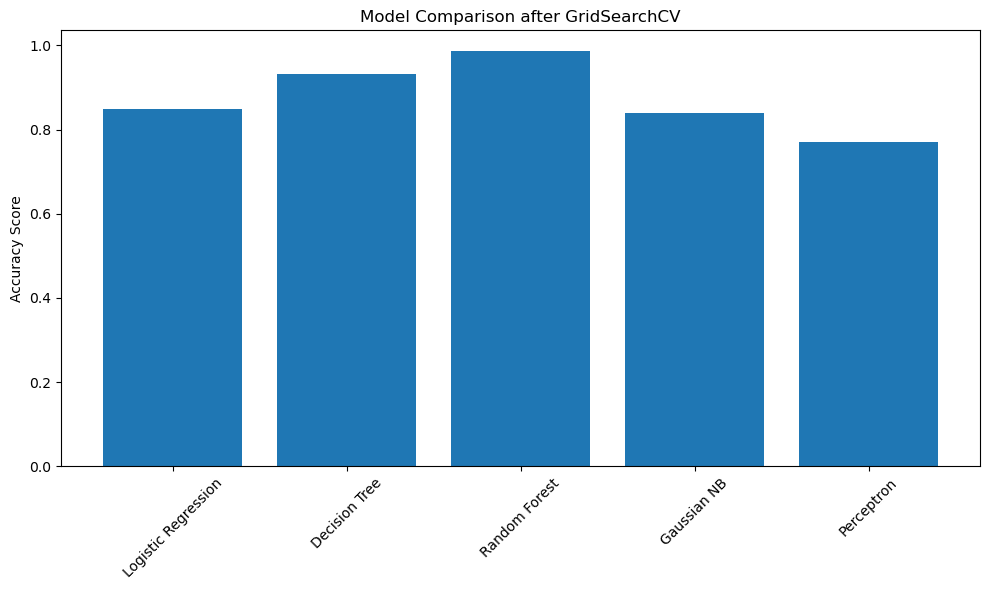


Best Overall Model: Random Forest
Best Overall Score: 0.9867

Test Set Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       740
           1       1.00      0.94      0.97       142

    accuracy                           0.99       882
   macro avg       0.99      0.97      0.98       882
weighted avg       0.99      0.99      0.99       882



In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Dictionary of models and their hyperparameters
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'max_features': ['auto', 'sqrt']
        }
    },
    'Gaussian NB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'Perceptron': {
        'model': Perceptron(),
        'params': {
            'penalty': [None, 'l1', 'l2'],
            'alpha': [0.0001, 0.001, 0.01],
            'max_iter': [1000]
        }
    }
}

# Perform GridSearch for each model
best_scores = {}
best_models = {}

for model_name, mp in model_params.items():
    print(f'\nTraining {model_name}...')
    
    # Create GridSearch object
    grid_search = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=10,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store best score and parameters
    best_scores[model_name] = {
        'Best Score': grid_search.best_score_,
        'Best Parameters': grid_search.best_params_
    }
    
    # Store best model
    best_models[model_name] = grid_search.best_estimator_

# Print results
for model_name, scores in best_scores.items():
    print(f'\n{model_name}:')
    print(f"Best Score: {scores['Best Score']:.4f}")
    print(f"Best Parameters: {scores['Best Parameters']}")

# Visualize results
plt.figure(figsize=(10, 6))
scores = [score['Best Score'] for score in best_scores.values()]
plt.bar(best_scores.keys(), scores)
plt.xticks(rotation=45)
plt.ylabel('Accuracy Score')
plt.title('Model Comparison after GridSearchCV')
plt.tight_layout()
plt.show()

# Find the best overall model
best_model_name = max(best_scores.items(), key=lambda x: x[1]['Best Score'])[0]
best_model = best_models[best_model_name]

print(f"\nBest Overall Model: {best_model_name}")
print(f"Best Overall Score: {best_scores[best_model_name]['Best Score']:.4f}")

# Evaluate best model on test set
y_pred = best_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))

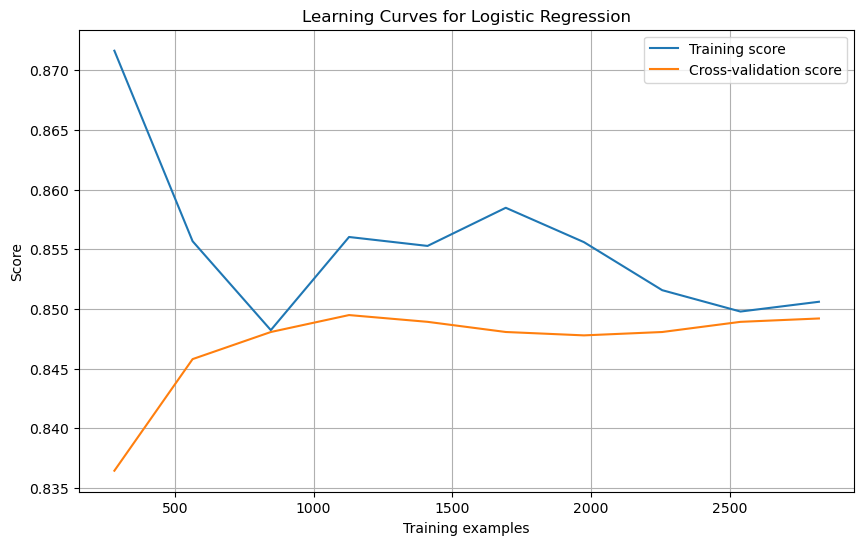

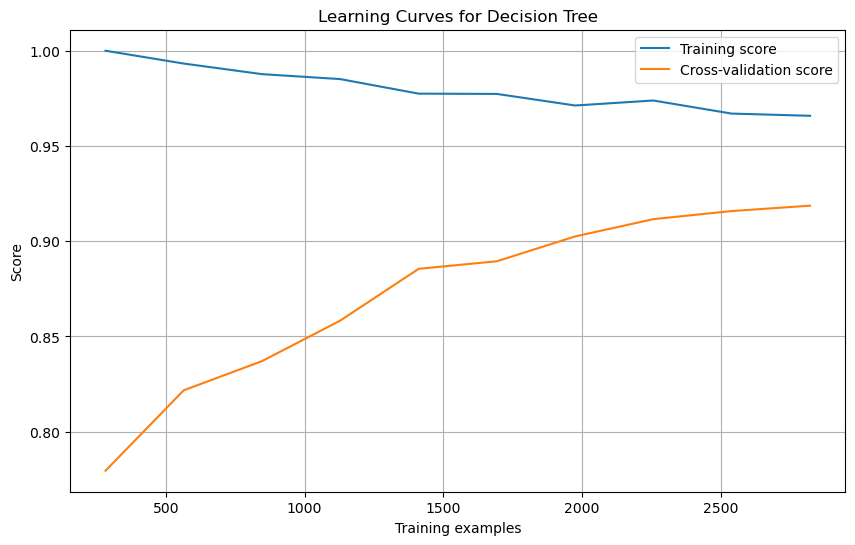

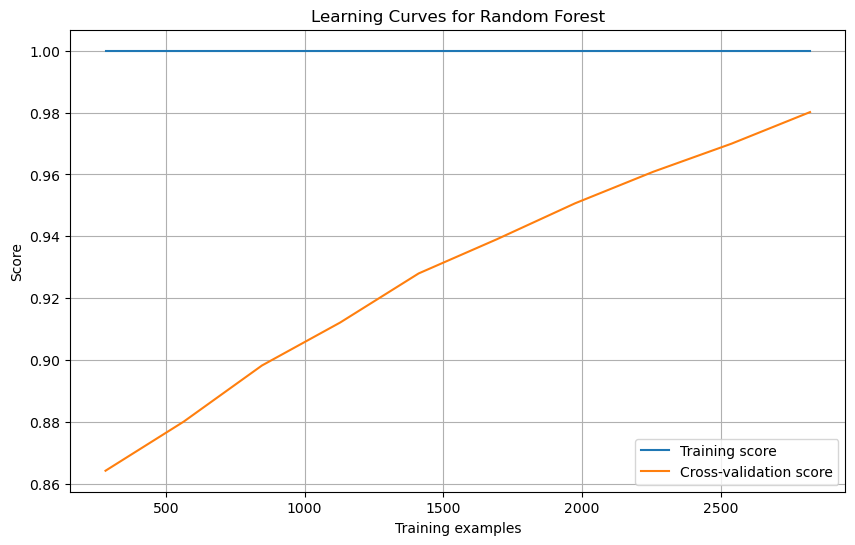

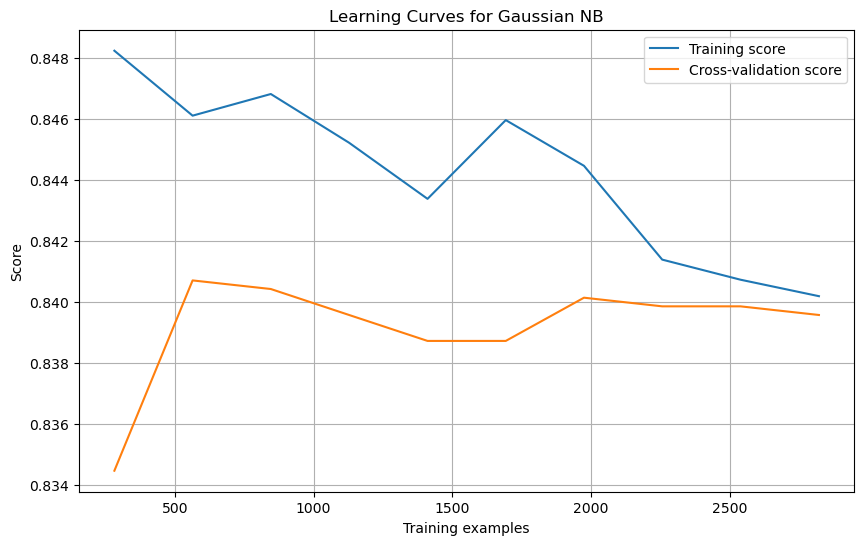

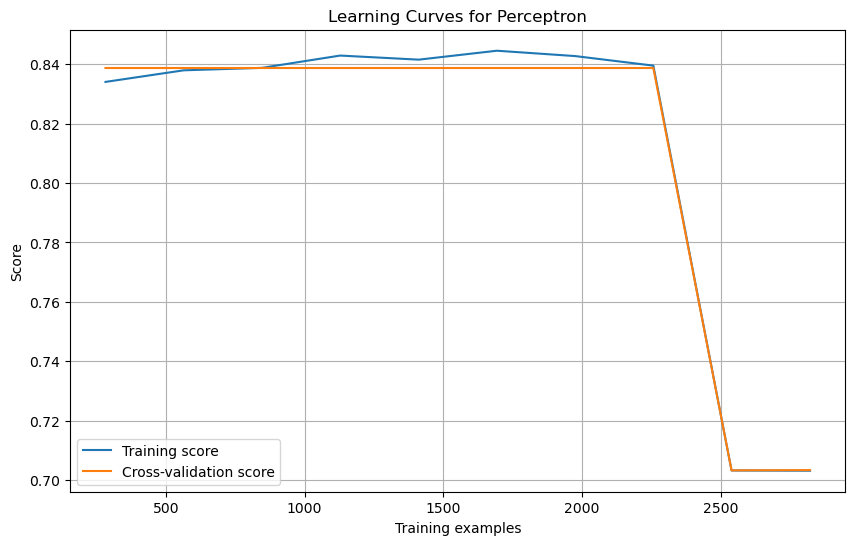

c:\Users\issam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x600 with 0 Axes>

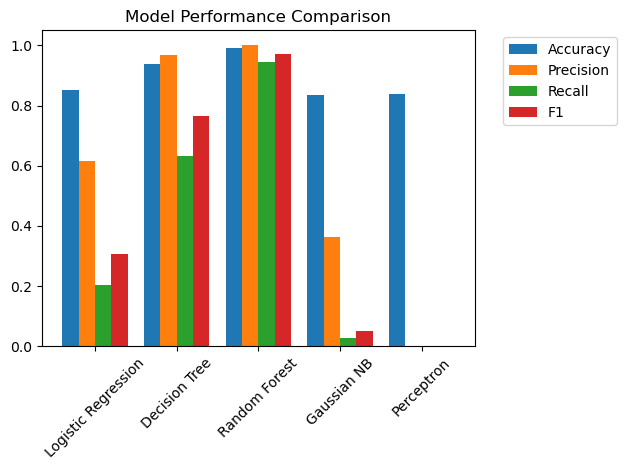

Some models don't support probability predictions


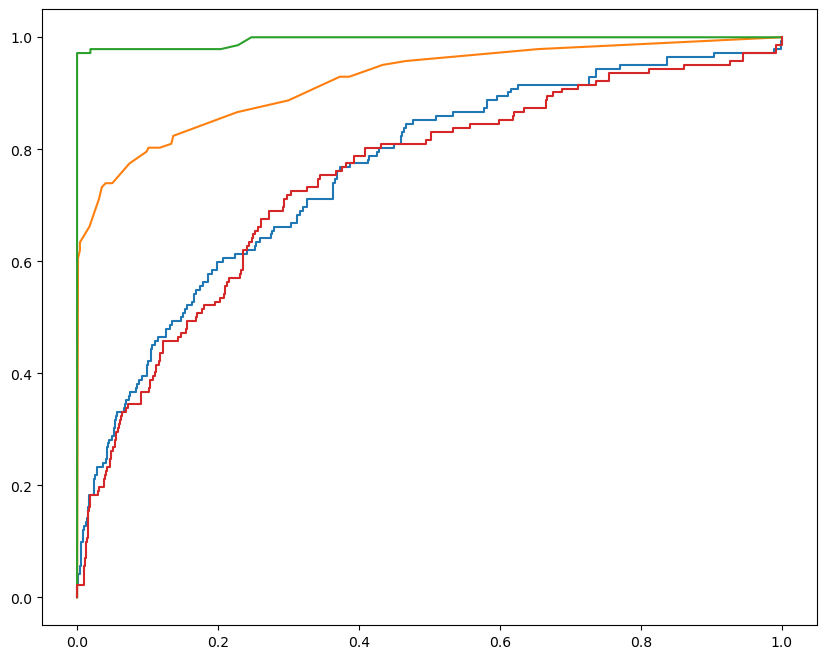

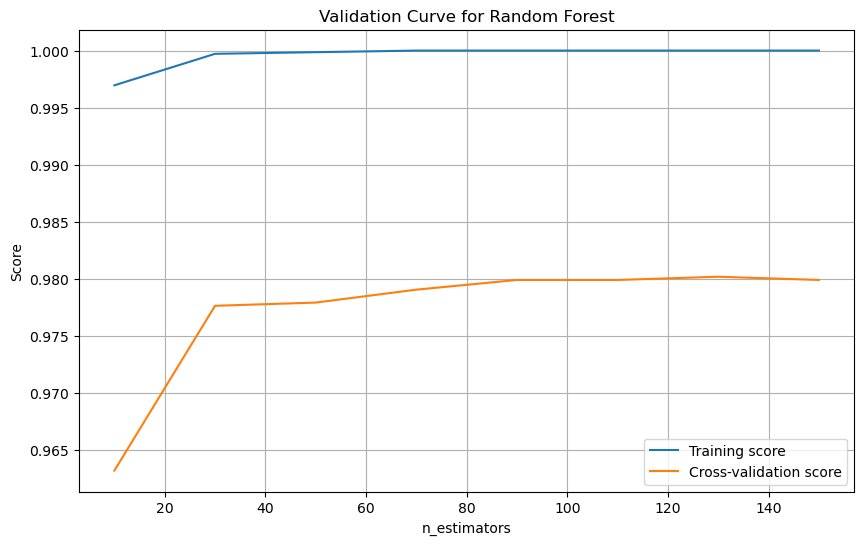

In [ ]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# 1. Learning Curves for Best Models
def plot_learning_curves(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curves for {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves for each best model
for name, model in best_models.items():
    plot_learning_curves(model, X_train, y_train, name)

# 2. Hyperparameter Heat Maps (for models with 2 main hyperparameters)
def plot_param_heatmap(grid_search, param1, param2, model_name):
    scores = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_['params']
    
    # Extract unique values for both parameters
    p1_values = sorted(set(p[param1] for p in params))
    p2_values = sorted(set(p[param2] for p in params))
    
    # Create score matrix
    score_matrix = np.zeros((len(p1_values), len(p2_values)))
    for i, p1 in enumerate(p1_values):
        for j, p2 in enumerate(p2_values):
            for idx, param in enumerate(params):
                if param[param1] == p1 and param[param2] == p2:
                    score_matrix[i, j] = scores[idx]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(score_matrix, annot=True, fmt='.3f', 
                xticklabels=p2_values, yticklabels=p1_values)
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.title(f'Hyperparameter Heatmap for {model_name}')
    plt.show()

# 3. Parameter Importance Plot (Random Forest)
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)



# 4. Model Performance Comparison
def plot_model_metrics():
    metrics = {}
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        metrics[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred)
        }
    
    metrics_df = pd.DataFrame(metrics).T
    
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar', width=0.8)
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

plot_model_metrics()

# 5. ROC Curves
def plot_roc_curves():
    plt.figure(figsize=(10, 8))
    for name, model in best_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.show()

# Make sure models have predict_proba method before calling
try:
    plot_roc_curves()
except:
    print("Some models don't support probability predictions")

# 6. Validation Curves for specific parameters
def plot_validation_curve(model, param_name, param_range, model_name):
    train_scores, val_scores = validation_curve(
        model, X_train, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=5, scoring='accuracy'
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(param_range, np.mean(val_scores, axis=1), label='Cross-validation score')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.title(f'Validation Curve for {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example for Random Forest n_estimators
if 'Random Forest' in best_models:
    plot_validation_curve(
        RandomForestClassifier(),
        "n_estimators",
        [10, 30, 50, 70, 90, 110, 130, 150],
        "Random Forest"
    )

Après comparaison des métriques combinées de précision, d'exactitude, de recall, et le F1, on constate que:
Random Forest est le meilleur modèle, car il a une précision, un recall et un F1-score élevés.
SVC est très précis mais a un faible recall, donc il ne détecte pas bien les cas positifs.
Naïve Bayes et Logistic Regression ont un recall faible, ce qui signifie qu'ils manquent des cas positifs.
Decision Tree est un bon compromis, mais moins performant que Random Forest.

c:\Users\issam\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


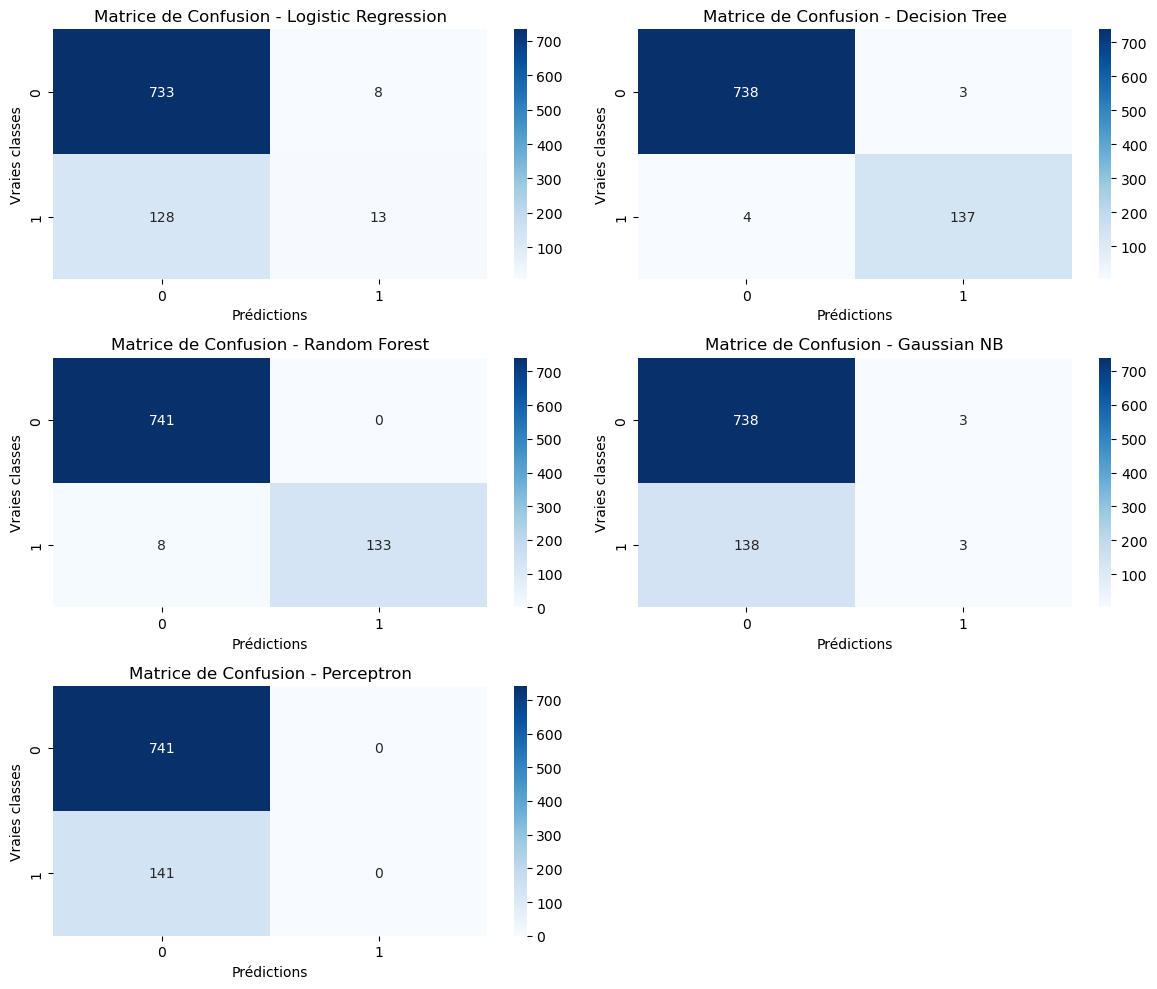

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Chargement des données (exemple avec X et y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des modèles à tester
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gaussian NB": GaussianNB(),
    "Perceptron": Perceptron()
}

# Création des matrices de confusion
plt.figure(figsize=(12, 10))
for i, (name, model) in enumerate(models.items(), 1):
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Affichage
    plt.subplot(3, 2, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Matrice de Confusion - {name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")

plt.tight_layout()
plt.show()


Une matrice de confusion montre la performance d’un modèle de classification en comparant ses prédictions aux valeurs réelles.

Les valeurs diagonales (haut gauche et bas droite) sont les bonnes prédictions (vrais positifs et vrais négatifs).
Les valeurs hors diagonale (haut droite et bas gauche) sont les erreurs (faux positifs et faux négatifs).


Ici, on costate que:
Random Forest et Decision Tree détectent bien les deux classes.
SVC et Perceptron classent tout en 0 (aucune détection de la classe 1).
Naïve Bayes fait beaucoup d’erreurs, notamment en confondant la classe 1 avec la classe 0.
Logistic Regression est correcte mais manque des cas positifs (beaucoup de faux négatifs).



Importance des caractéristiques pour l'attrition :
                    Feature  Importance
9         TotalWorkingYears    0.131517
16          AttendanceScore    0.108786
7             MonthlyIncome    0.108631
17       PromotionFrequency    0.074756
2          DistanceFromHome    0.074611
8        NumCompaniesWorked    0.057854
6                   JobRole    0.054666
11  EnvironmentSatisfaction    0.048851
10    TrainingTimesLastYear    0.043679
13          WorkLifeBalance    0.042881
4            EducationField    0.042190
12          JobSatisfaction    0.040341
3                 Education    0.038929
5                  JobLevel    0.036679
14           JobInvolvement    0.033733
1                Department    0.024246
0            BusinessTravel    0.024182
15        PerformanceRating    0.013467


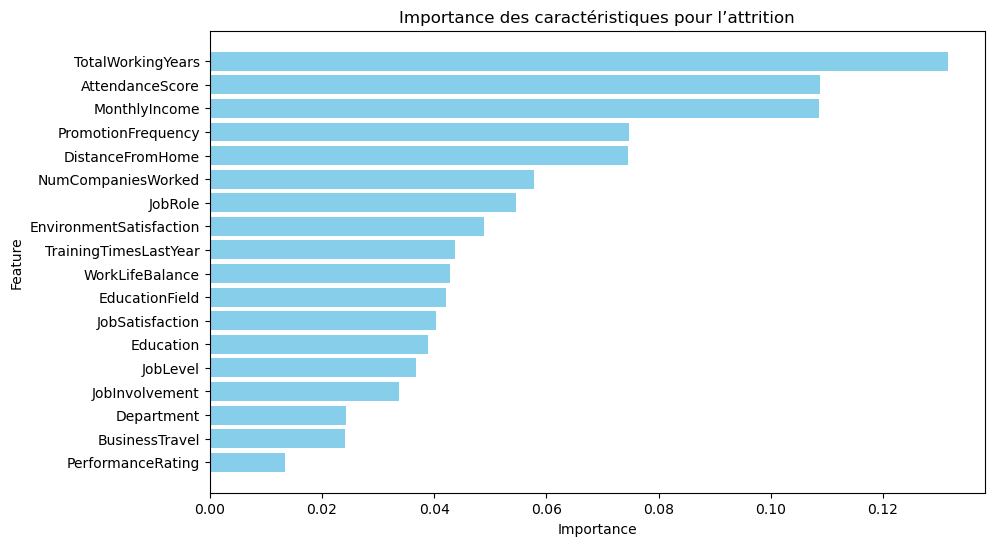

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Vérifier si le meilleur modèle est Random Forest
if best_model_name == "Random Forest":
    rf_model = best_model  # Prendre le meilleur modèle trouvé par GridSearchCV

    # Vérifier si le modèle a des importances de caractéristiques
    if hasattr(rf_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        # Afficher le tableau des importances
        print("\nImportance des caractéristiques pour l'attrition :")
        print(feature_importance)

        # Afficher un graphique des importances
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Importance des caractéristiques pour l’attrition')
        plt.gca().invert_yaxis()  # Inverser l'ordre pour que les plus importantes soient en haut
        plt.show()
    else:
        print("Le modèle Random Forest sélectionné ne possède pas d'attribut 'feature_importances_'.")
else:
    print(f"Le meilleur modèle trouvé par GridSearchCV est {best_model_name}, pas Random Forest.")


On constate que les 5 caractéstiques les plus importantes pour l'attrition sont : TotalWorrkingYears, AttendanceScore, MonthlyIncome et PromotionFrequency dans une moindre mesure, avec DistanceFromHome.

En se basant sur ces dernières données et leur graphique, il est possible de confirmer nos théories antérieures avant entrainement des modèles; excepté la théorie de la corrélation entre les départs et le département RH. 

Les solutions que l'on peut proposer pour pallier aux facteurs favorisant le départ des employés sont:

_Réguler les horaires de travail des employés

_Augmenter les salaires 

_Axer le recrutement sur des personnes avec de l'expérience professionnelle antérieure

_Proposer des solutions de transport pour les employés habitant loin de l'entreprise ou si possible des solutions de télétravail.
